In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
pd.set_option('future.no_silent_downcasting', True)

In [4]:
import torch
torch.cuda.is_available()

True

In [5]:
path = "./comodity-price-prediction-penyisihan-arkavidia-9/Harga Bahan Pangan/"
path_train = np.sort(os.listdir(path + "train"))
path_test = np.sort(os.listdir(path + "test"))

In [6]:
path_train

array(['Bawang Merah.csv', 'Bawang Putih Bonggol.csv', 'Beras Medium.csv',
       'Beras Premium.csv', 'Cabai Merah Keriting.csv',
       'Cabai Rawit Merah.csv', 'Daging Ayam Ras.csv',
       'Daging Sapi Murni.csv', 'Gula Konsumsi.csv',
       'Minyak Goreng Curah.csv', 'Minyak Goreng Kemasan Sederhana.csv',
       'Telur Ayam Ras.csv', 'Tepung Terigu (Curah).csv'], dtype='<U35')

In [7]:
path_train[0]

np.str_('Bawang Merah.csv')

In [8]:
df_train = [pd.read_csv(path + "train/" + data) for data in path_train]

for i, df_pangan in enumerate(df_train):
    df_pangan["Pangan"] = path_train[i].replace(".csv", "")

df_train = pd.concat(df_train, axis=0, ignore_index=True)
df_train["Date"] = pd.to_datetime(df_train["Date"])
df_train = df_train.set_index("Date")

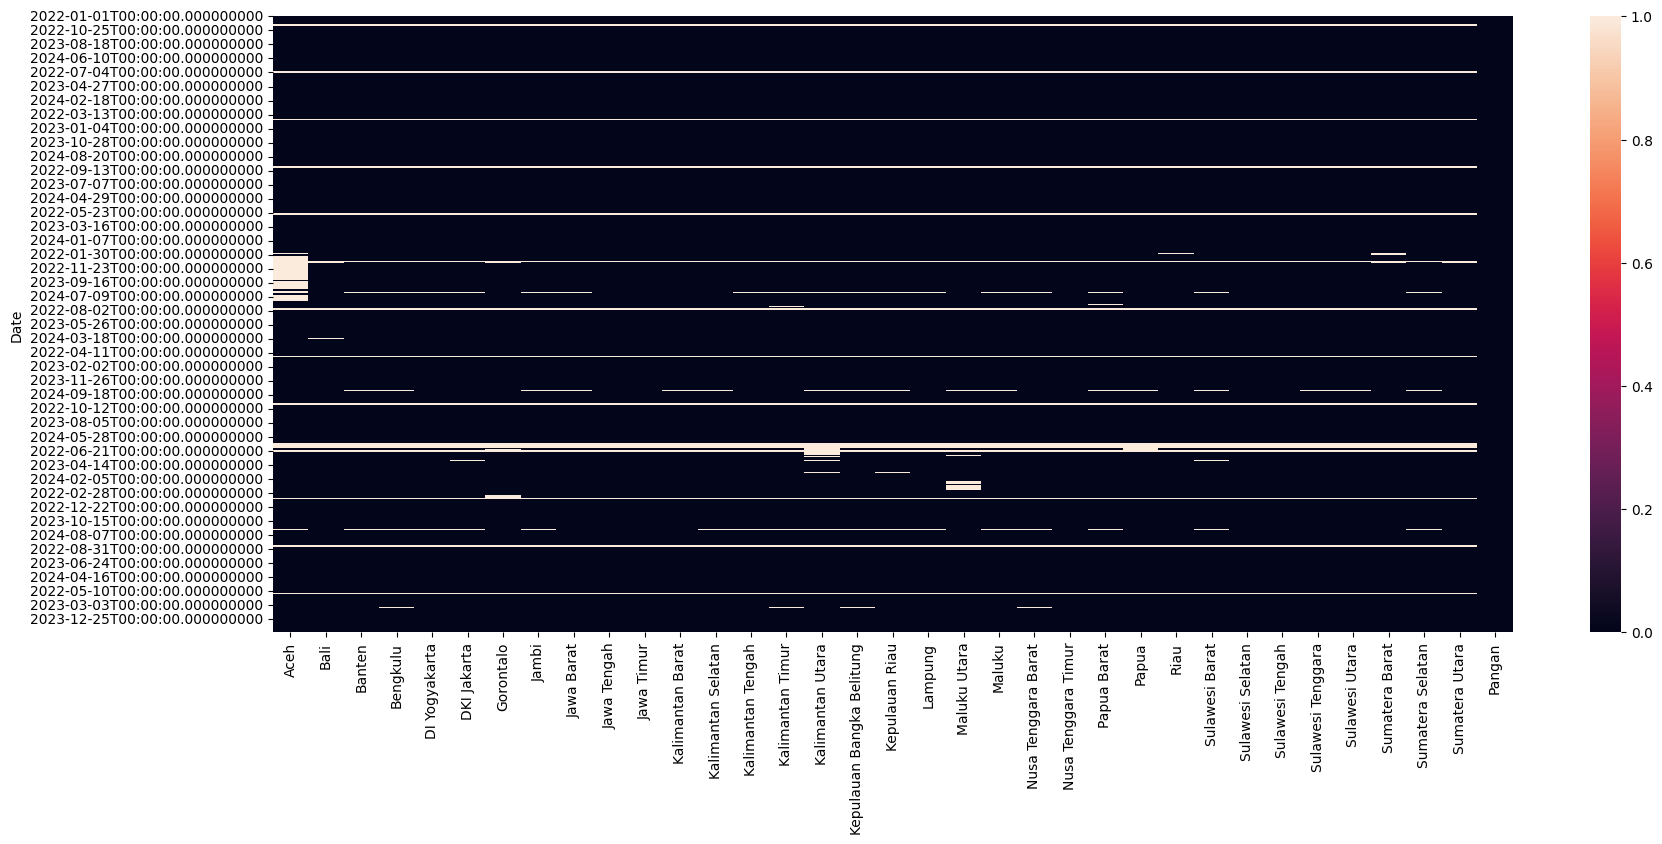

In [9]:
fig, ax = plt.subplots(figsize=(20, 8))
sns.heatmap(df_train.isna(), ax=ax);

In [10]:
list_provinsi = df_train.columns[:-1].to_list()

<Axes: xlabel='Date'>

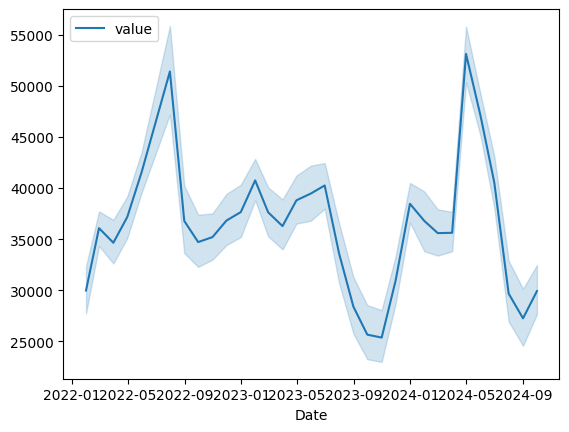

In [11]:
bawang_merah = df_train.loc[df_train["Pangan"] == "Bawang Merah", list_provinsi].asfreq("ME").T.melt().set_index("Date")
sns.lineplot(bawang_merah)

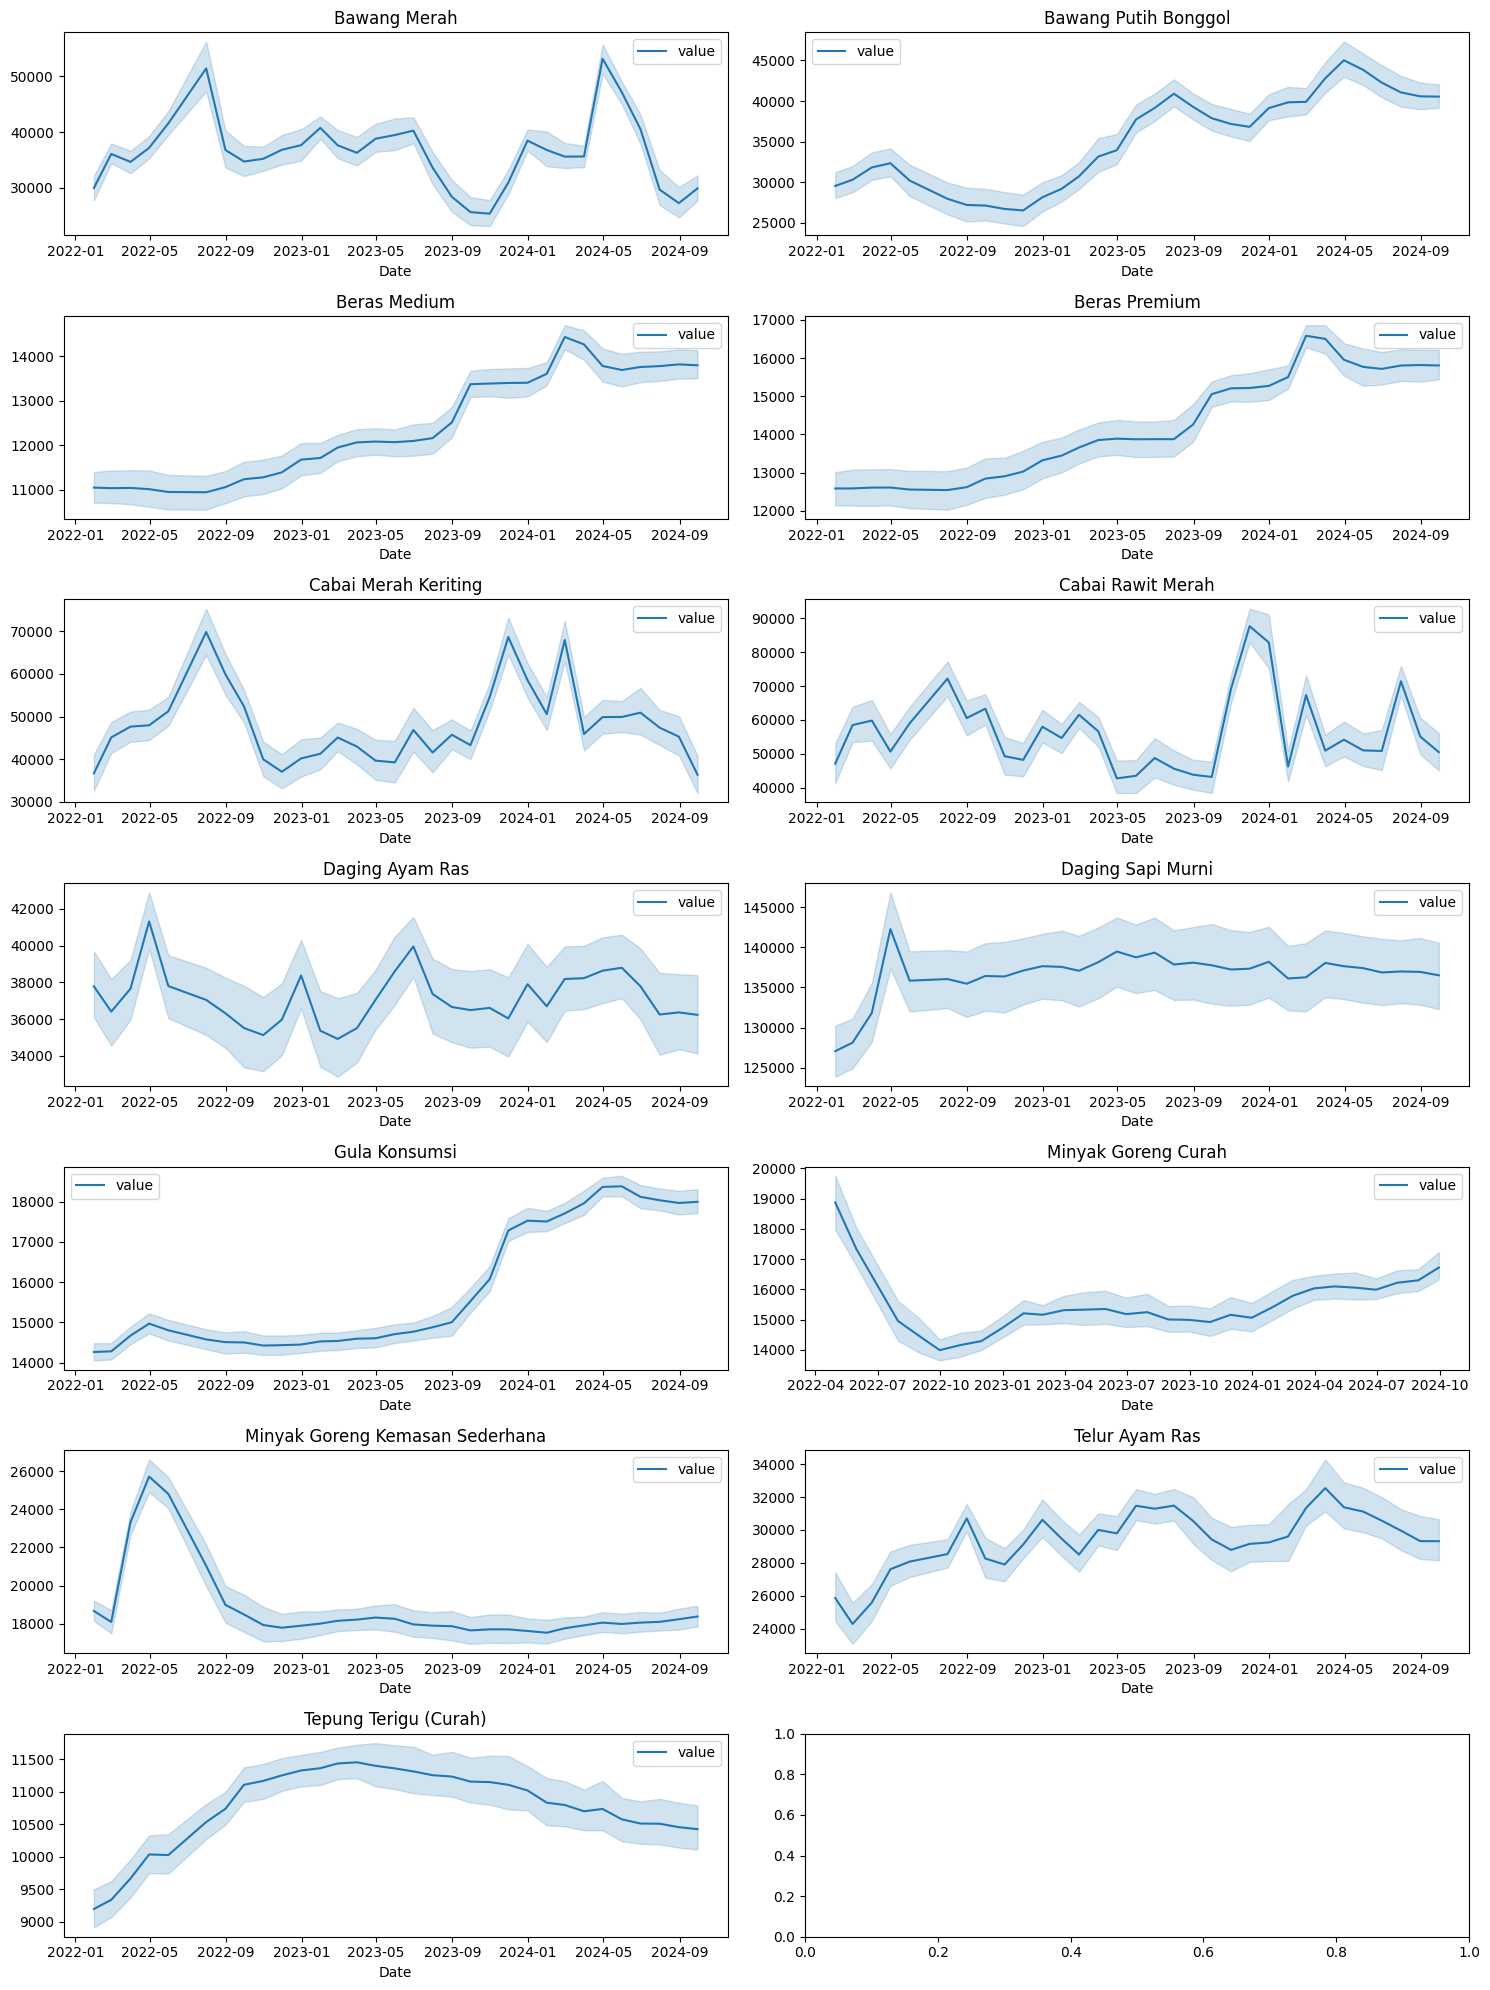

In [12]:
bahan_pangan = df_train["Pangan"].unique()

fig, ax = plt.subplots(int(len(bahan_pangan)/2) + 1, 2, figsize=(15, 20))
ax = ax.flatten()

for i, pangan in enumerate(bahan_pangan):
    groupby_pangan = df_train.loc[df_train["Pangan"] == pangan, list_provinsi].asfreq("ME").T.melt().set_index("Date")
    sns.lineplot(groupby_pangan, ax=ax[i])
    ax[i].title.set_text(pangan)
    
plt.tight_layout()

In [13]:
import copy
from sklearn.impute import KNNImputer

In [14]:
for pangan in bahan_pangan:
    pangan_df = df_train[df_train["Pangan"] == pangan]
    for prov in list_provinsi:
        df_train.loc[df_train["Pangan"] == pangan, prov] = df_train.loc[df_train["Pangan"] == pangan, prov].interpolate(method="time")
        df_train.loc[df_train["Pangan"] == pangan, prov] = df_train.loc[df_train["Pangan"] == pangan, prov].bfill()
        df_train.loc[df_train["Pangan"] == pangan, prov] = df_train.loc[df_train["Pangan"] == pangan, prov].ffill()
        df_train.loc[df_train["Pangan"] == pangan, prov] = df_train.loc[df_train["Pangan"] == pangan, prov].round(-1)
        

In [15]:
# model_xgb = xgb.XGBRegressor(n_estimators=50, learning_rate=0.1)

# for pangan in bahan_pangan:
#     pangan_df = df_train[df_train["Pangan"] == pangan]
#     pangan_df = pangan_df.drop(columns=["Pangan"])
#     for prov in list_provinsi:
#         train_data = pangan_df.dropna()
#         test_data = pangan_df[pangan_df[prov].isna()]
#         test_data = test_data.drop(columns=[prov])
    
#         train_x = train_data.drop(columns=[prov])
#         train_y = train_data[prov]

#         model_xgb.fit(train_x, train_y)

#         missing_pred = model_xgb.predict(test_data)
        
#         df_train.loc[(df_train["Pangan"] == pangan) & (df_train[prov].isna()), prov] = missing_pred

In [16]:
from sklearn.metrics import mean_absolute_percentage_error
import logging
from sklearn.preprocessing import MinMaxScaler

In [17]:
df_train = df_train.reset_index().rename(columns={"Date":"ds"})

In [18]:
path_commodity = "./comodity-price-prediction-penyisihan-arkavidia-9/Global Commodity Price/"
path_commodity_list = os.listdir(path_commodity)

commodity_df = [pd.read_csv(path_commodity + path)[["Date","Price"]].sort_values("Date") for path in path_commodity_list] 

for i, df_commodity in enumerate(commodity_df):
    df_commodity["Commodity"] = path_commodity_list[i].replace(".csv", "")

rename_commodity = {"Crude Oil WTI Futures Historical Data" : 1, 
                    "Natural Gas Futures Historical Data" : 2, 
                    "Newcastle Coal Futures Historical Data" : 3, 
                    "Palm Oil Futures Historical Data" : 4, 
                    "US Sugar 11 Futures Historical Data" : 5, 
                    "US Wheat Futures Historical Data" : 6}

commodity_df = pd.concat(commodity_df, axis=0, ignore_index=True)
commodity_df = commodity_df.rename(columns={"Date":"ds"})

commodity_df["ds"] = pd.to_datetime(commodity_df["ds"])
commodity_df["Commodity"] = commodity_df["Commodity"].replace(rename_commodity)
commodity_df["Price"] = commodity_df["Price"].apply(lambda x : str(x).replace(",", "")).astype(np.float64)

In [19]:
for i in range(1, 7):
    commodity = commodity_df[commodity_df["Commodity"] == i][["ds", "Price"]].rename(columns={"Price" : f"Com{i}"}).reset_index(drop=True)
    commodity_df = pd.merge(commodity_df, commodity, on="ds", sort=True)
    
commodity_df = commodity_df.drop(columns=["Price", "Commodity"])
commodity_df = commodity_df.drop_duplicates().reset_index(drop=True)

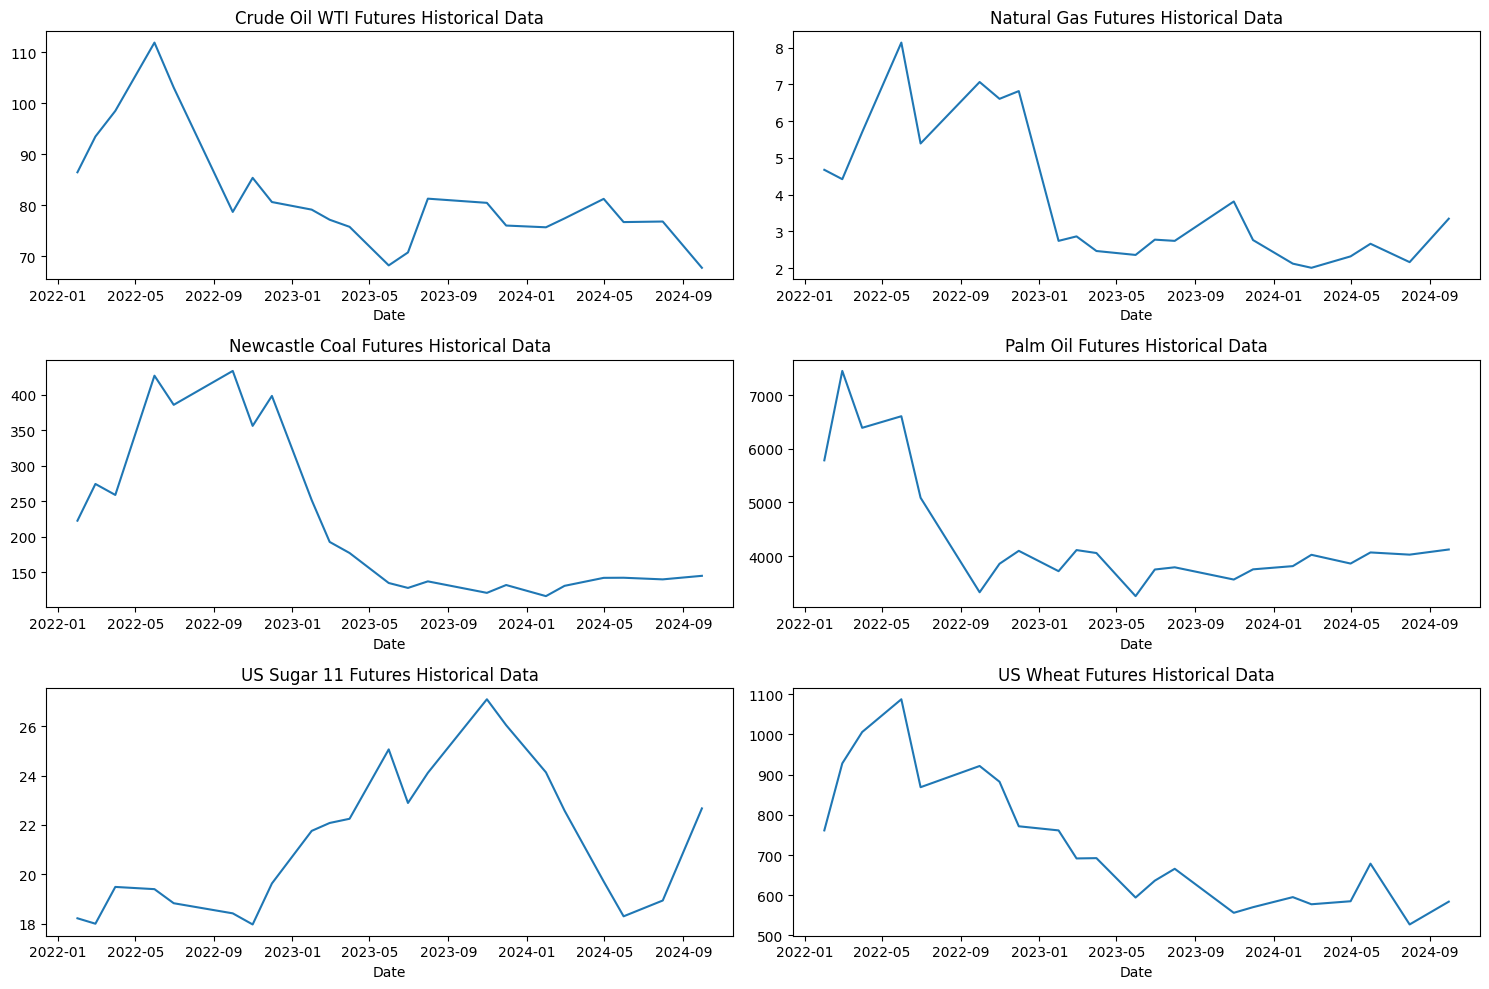

In [20]:
plt.figure(figsize=(15, 10))

for i in range(1, 7):
    plt.subplot(3, 2, i)
    sns.lineplot(commodity_df.set_index("ds").asfreq("ME"),x="ds", y=f"Com{i}")
    plt.xlabel("Date")
    plt.ylabel("")
    plt.title(f"{list(rename_commodity.keys())[i - 1]}")
    
plt.tight_layout()

In [21]:
path_exchange = "./comodity-price-prediction-penyisihan-arkavidia-9/Mata Uang/"
path_exchange_list = os.listdir(path_exchange)

exchange_list = {"MYRUSD=X" : "MYR", "SGDUSD=X" : "SGD", "THUSD=X" : "THB", "USDIDR=X" : "IDR"}

exchange_df = [pd.read_csv(path_exchange + path)[["Date","Adj Close"]].sort_values("Date") for path in path_exchange_list]

for i, df_exchange in enumerate(exchange_df):
    exchange_name = path_exchange_list[i].replace(".csv", "")
    exchange_df[i] = df_exchange.rename(columns={"Adj Close" : exchange_name})
    if i > 0:
        exchange_df[i] = exchange_df[i].drop(columns=["Date"])
    
df_exchange = pd.concat(exchange_df, axis=1)
df_exchange = df_exchange.rename(columns=exchange_list)
df_exchange = df_exchange.rename(columns={"Date":"ds"})
df_exchange["ds"] = pd.to_datetime(df_exchange["ds"])
df_exchange

,ds,MYR,SGD,THBUSD=X,IDR
0,2022-01-03,0.239521,0.741730,0.030201,14215.000000
1,2022-01-04,0.239808,0.739033,0.030082,14283.599609
2,2022-01-05,0.239006,0.737621,0.030083,14385.500000
3,2022-01-06,0.238550,0.736534,0.030077,14446.500000
4,2022-01-07,0.237473,0.734786,0.029804,14408.000000
...,...,...,...,...,...
711,2024-09-24,0.238067,0.774647,0.030377,15174.099609
712,2024-09-25,0.240964,0.779812,0.030710,15121.099609
713,2024-09-26,0.242219,0.775326,0.030516,15201.500000
714,2024-09-27,0.241546,0.778889,0.030897,15070.000000


### TiDE Model

In [23]:
from neuralforecast import NeuralForecast
from neuralforecast.models import TimeXer, TFT, TiDE
from neuralforecast.losses.pytorch import MAPE

C:\Users\Yani Dwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-14 22:35:27,810	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-03-14 22:35:29,459	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [ ]:
ypred_list = []
id_list = []
for bahan in bahan_pangan:
    print("=" * 5,bahan, "=" * 5)
    for prov in list_provinsi:
        print(prov)
        df_prov_train = df_train[df_train["Pangan"] == bahan][["ds", prov]]
        df_prov_train = df_prov_train.rename(columns={prov:"y"})
        
        val_size = int(len(df_prov_train) * 0.15)
        corr_tolerance = 0.5
        
        df_prov_train = pd.merge(df_prov_train, commodity_df, on="ds", how="left")
        df_prov_train = pd.merge(df_prov_train, df_exchange, on="ds", how="left")
        
        corr_features = df_prov_train.corr()["y"][2:]
        corr_features = corr_features[np.abs(corr_features) > corr_tolerance].index.to_list()
        corr_features.insert(0, "ds")
        corr_features.insert(1, "y")
        
        df_prov_train = df_prov_train[corr_features]
        df_prov_train = df_prov_train.set_index("ds")
        
        df_prov_train = df_prov_train.interpolate(method="time")
        df_prov_train = df_prov_train.bfill()
        df_prov_train = df_prov_train.ffill()
        df_prov_train = df_prov_train.reset_index()
        
        for ex in corr_features[2:]:     
            scaler = MinMaxScaler()
            df_prov_train[ex] = scaler.fit_transform(df_prov_train[[ex]])
    
        df_futures = pd.read_csv(path + f"test/Gula Konsumsi.csv").rename(columns={"Date":"ds"})[["ds"]]
        df_futures = pd.to_datetime(df_futures["ds"])
        df_futures = df_futures.reset_index().rename(columns={"index":"unique_id"})
        df_futures["unique_id"] = 1
            
        df_prov_train = df_prov_train.reset_index().rename(columns={"index":"unique_id"})
        df_prov_train["unique_id"] = 1
        
        model_timexer = TiDE(h=len(df_futures),
                            input_size=val_size + 24,
                            loss=MAPE(),
                            valid_loss = MAPE(),
                            max_steps=50,
                            val_check_steps=5,
                            hist_exog_list=corr_features[2:],
                            batch_size=128)
    
        forecast = NeuralForecast(
            models=[model_timexer],
            freq="D"
        )
        
        forecast.fit(df_prov_train, val_size=val_size, verbose=False)
        ypred = forecast.predict(futr_df=df_futures, verbose=False)
        
        id_name = df_futures["ds"].apply(lambda x : f"{bahan}/{prov}/{str(x)}")
        id_list.append(np.array(id_name))
        
        ypred_list.append(np.array(ypred))

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


===== Bawang Merah =====
Aceh


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.07it/s, v_num=5464, train_loss_step=0.169, train_loss_epoch=0.169, valid_loss=0.278]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.30it/s, v_num=5464, train_loss_step=0.169, train_loss_epoch=0.169, valid_loss=0.278]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.09it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Bali


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.27it/s, v_num=5466, train_loss_step=0.200, train_loss_epoch=0.200, valid_loss=0.246]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.66it/s, v_num=5466, train_loss_step=0.200, train_loss_epoch=0.200, valid_loss=0.246]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 164.91it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Banten


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.55it/s, v_num=5468, train_loss_step=0.190, train_loss_epoch=0.190, valid_loss=0.204]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.72it/s, v_num=5468, train_loss_step=0.190, train_loss_epoch=0.190, valid_loss=0.204]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.08it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Bengkulu


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.15it/s, v_num=5470, train_loss_step=0.186, train_loss_epoch=0.186, valid_loss=0.266]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.43it/s, v_num=5470, train_loss_step=0.186, train_loss_epoch=0.186, valid_loss=0.266]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 168.28it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



DI Yogyakarta


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.44it/s, v_num=5472, train_loss_step=0.234, train_loss_epoch=0.234, valid_loss=0.311]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.39it/s, v_num=5472, train_loss_step=0.234, train_loss_epoch=0.234, valid_loss=0.311]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 176.73it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



DKI Jakarta


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.82it/s, v_num=5474, train_loss_step=0.161, train_loss_epoch=0.161, valid_loss=0.225]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.87it/s, v_num=5474, train_loss_step=0.161, train_loss_epoch=0.161, valid_loss=0.225]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 165.91it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Gorontalo


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.14it/s, v_num=5476, train_loss_step=0.208, train_loss_epoch=0.208, valid_loss=0.217]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.43it/s, v_num=5476, train_loss_step=0.208, train_loss_epoch=0.208, valid_loss=0.217]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.19it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jambi


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.04it/s, v_num=5478, train_loss_step=0.189, train_loss_epoch=0.189, valid_loss=0.241]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.18it/s, v_num=5478, train_loss_step=0.189, train_loss_epoch=0.189, valid_loss=0.241]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.95it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jawa Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.24it/s, v_num=5480, train_loss_step=0.183, train_loss_epoch=0.183, valid_loss=0.205]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.21it/s, v_num=5480, train_loss_step=0.183, train_loss_epoch=0.183, valid_loss=0.205]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.51it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jawa Tengah


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.47it/s, v_num=5482, train_loss_step=0.208, train_loss_epoch=0.208, valid_loss=0.245]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.50it/s, v_num=5482, train_loss_step=0.208, train_loss_epoch=0.208, valid_loss=0.245]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 147.48it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jawa Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.06it/s, v_num=5484, train_loss_step=0.220, train_loss_epoch=0.220, valid_loss=0.300]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 14.34it/s, v_num=5484, train_loss_step=0.220, train_loss_epoch=0.220, valid_loss=0.300]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 185.37it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.14it/s, v_num=5486, train_loss_step=0.139, train_loss_epoch=0.139, valid_loss=0.154]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.50it/s, v_num=5486, train_loss_step=0.139, train_loss_epoch=0.139, valid_loss=0.154]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.84it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Selatan


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.40it/s, v_num=5488, train_loss_step=0.202, train_loss_epoch=0.202, valid_loss=0.211]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.39it/s, v_num=5488, train_loss_step=0.202, train_loss_epoch=0.202, valid_loss=0.211]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.40it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Tengah


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.81it/s, v_num=5490, train_loss_step=0.170, train_loss_epoch=0.170, valid_loss=0.193]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.07it/s, v_num=5490, train_loss_step=0.170, train_loss_epoch=0.170, valid_loss=0.193]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 180.35it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.96it/s, v_num=5492, train_loss_step=0.168, train_loss_epoch=0.168, valid_loss=0.153]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.37it/s, v_num=5492, train_loss_step=0.168, train_loss_epoch=0.168, valid_loss=0.153]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 171.20it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.29it/s, v_num=5494, train_loss_step=0.132, train_loss_epoch=0.132, valid_loss=0.156]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.65it/s, v_num=5494, train_loss_step=0.132, train_loss_epoch=0.132, valid_loss=0.156]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 188.25it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kepulauan Bangka Belitung


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.55it/s, v_num=5496, train_loss_step=0.199, train_loss_epoch=0.199, valid_loss=0.250]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.58it/s, v_num=5496, train_loss_step=0.199, train_loss_epoch=0.199, valid_loss=0.250]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 162.05it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kepulauan Riau


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.07it/s, v_num=5498, train_loss_step=0.0866, train_loss_epoch=0.0866, valid_loss=0.0627]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.26it/s, v_num=5498, train_loss_step=0.0866, train_loss_epoch=0.0866, valid_loss=0.0627]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 172.63it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Lampung


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.91it/s, v_num=5500, train_loss_step=0.216, train_loss_epoch=0.216, valid_loss=0.292]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.83it/s, v_num=5500, train_loss_step=0.216, train_loss_epoch=0.216, valid_loss=0.292]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.84it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Maluku Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.79it/s, v_num=5502, train_loss_step=0.130, train_loss_epoch=0.130, valid_loss=0.106]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.18it/s, v_num=5502, train_loss_step=0.130, train_loss_epoch=0.130, valid_loss=0.106]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 158.08it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Maluku


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.93it/s, v_num=5504, train_loss_step=0.126, train_loss_epoch=0.126, valid_loss=0.140]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.23it/s, v_num=5504, train_loss_step=0.126, train_loss_epoch=0.126, valid_loss=0.140]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.75it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Nusa Tenggara Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.34it/s, v_num=5506, train_loss_step=0.248, train_loss_epoch=0.248, valid_loss=0.362]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.41it/s, v_num=5506, train_loss_step=0.248, train_loss_epoch=0.248, valid_loss=0.362]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 191.62it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Nusa Tenggara Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.54it/s, v_num=5508, train_loss_step=0.223, train_loss_epoch=0.223, valid_loss=0.290]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.52it/s, v_num=5508, train_loss_step=0.223, train_loss_epoch=0.223, valid_loss=0.290]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 195.91it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Papua Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.23it/s, v_num=5510, train_loss_step=0.101, train_loss_epoch=0.101, valid_loss=0.0829]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.58it/s, v_num=5510, train_loss_step=0.101, train_loss_epoch=0.101, valid_loss=0.0829]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.71it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Papua


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.54it/s, v_num=5512, train_loss_step=0.0913, train_loss_epoch=0.0913, valid_loss=0.0986]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.01it/s, v_num=5512, train_loss_step=0.0913, train_loss_epoch=0.0913, valid_loss=0.0986]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.63it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Riau


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 14.42it/s, v_num=5514, train_loss_step=0.160, train_loss_epoch=0.160, valid_loss=0.256]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 13.61it/s, v_num=5514, train_loss_step=0.160, train_loss_epoch=0.160, valid_loss=0.256]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 162.31it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.22it/s, v_num=5516, train_loss_step=0.174, train_loss_epoch=0.174, valid_loss=0.199]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.47it/s, v_num=5516, train_loss_step=0.174, train_loss_epoch=0.174, valid_loss=0.199]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 164.99it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Selatan


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.40it/s, v_num=5518, train_loss_step=0.154, train_loss_epoch=0.154, valid_loss=0.226]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.73it/s, v_num=5518, train_loss_step=0.154, train_loss_epoch=0.154, valid_loss=0.226]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 183.51it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Tengah


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.34it/s, v_num=5520, train_loss_step=0.159, train_loss_epoch=0.159, valid_loss=0.182]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.69it/s, v_num=5520, train_loss_step=0.159, train_loss_epoch=0.159, valid_loss=0.182]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 193.63it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Tenggara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s, v_num=5522, train_loss_step=0.144, train_loss_epoch=0.144, valid_loss=0.212]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.87it/s, v_num=5522, train_loss_step=0.144, train_loss_epoch=0.144, valid_loss=0.212]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 153.97it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.78it/s, v_num=5524, train_loss_step=0.151, train_loss_epoch=0.151, valid_loss=0.180]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.88it/s, v_num=5524, train_loss_step=0.151, train_loss_epoch=0.151, valid_loss=0.180]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.90it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sumatera Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.58it/s, v_num=5526, train_loss_step=0.209, train_loss_epoch=0.209, valid_loss=0.273]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.67it/s, v_num=5526, train_loss_step=0.209, train_loss_epoch=0.209, valid_loss=0.273]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 159.27it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sumatera Selatan


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.25it/s, v_num=5528, train_loss_step=0.193, train_loss_epoch=0.193, valid_loss=0.280]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.33it/s, v_num=5528, train_loss_step=0.193, train_loss_epoch=0.193, valid_loss=0.280]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 161.02it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sumatera Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.51it/s, v_num=5530, train_loss_step=0.170, train_loss_epoch=0.170, valid_loss=0.227]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.91it/s, v_num=5530, train_loss_step=0.170, train_loss_epoch=0.170, valid_loss=0.227]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 159.33it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



===== Bawang Putih Bonggol =====
Aceh


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.81it/s, v_num=5532, train_loss_step=0.114, train_loss_epoch=0.114, valid_loss=0.0574]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 14.87it/s, v_num=5532, train_loss_step=0.114, train_loss_epoch=0.114, valid_loss=0.0574]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.47it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Bali


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.40it/s, v_num=5534, train_loss_step=0.138, train_loss_epoch=0.138, valid_loss=0.0731]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.54it/s, v_num=5534, train_loss_step=0.138, train_loss_epoch=0.138, valid_loss=0.0731]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 195.49it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Banten


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.71it/s, v_num=5536, train_loss_step=0.110, train_loss_epoch=0.110, valid_loss=0.0484]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.54it/s, v_num=5536, train_loss_step=0.110, train_loss_epoch=0.110, valid_loss=0.0484]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 177.48it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Bengkulu


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.83it/s, v_num=5538, train_loss_step=0.116, train_loss_epoch=0.116, valid_loss=0.0825]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.14it/s, v_num=5538, train_loss_step=0.116, train_loss_epoch=0.116, valid_loss=0.0825]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 165.47it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



DI Yogyakarta


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.07it/s, v_num=5540, train_loss_step=0.123, train_loss_epoch=0.123, valid_loss=0.0763]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.95it/s, v_num=5540, train_loss_step=0.123, train_loss_epoch=0.123, valid_loss=0.0763]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 157.44it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



DKI Jakarta


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.52it/s, v_num=5542, train_loss_step=0.0725, train_loss_epoch=0.0725, valid_loss=0.0557]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.57it/s, v_num=5542, train_loss_step=0.0725, train_loss_epoch=0.0725, valid_loss=0.0557]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 194.94it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Gorontalo


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.01it/s, v_num=5544, train_loss_step=0.113, train_loss_epoch=0.113, valid_loss=0.073] 

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.37it/s, v_num=5544, train_loss_step=0.113, train_loss_epoch=0.113, valid_loss=0.073]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.84it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jambi


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.69it/s, v_num=5546, train_loss_step=0.114, train_loss_epoch=0.114, valid_loss=0.0641]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.19it/s, v_num=5546, train_loss_step=0.114, train_loss_epoch=0.114, valid_loss=0.0641]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.94it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jawa Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.22it/s, v_num=5548, train_loss_step=0.107, train_loss_epoch=0.107, valid_loss=0.0469]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.59it/s, v_num=5548, train_loss_step=0.107, train_loss_epoch=0.107, valid_loss=0.0469]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 167.85it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jawa Tengah


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.40it/s, v_num=5550, train_loss_step=0.117, train_loss_epoch=0.117, valid_loss=0.067] 

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.47it/s, v_num=5550, train_loss_step=0.117, train_loss_epoch=0.117, valid_loss=0.067]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.93it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jawa Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 14.54it/s, v_num=5552, train_loss_step=0.126, train_loss_epoch=0.126, valid_loss=0.0701]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 13.25it/s, v_num=5552, train_loss_step=0.126, train_loss_epoch=0.126, valid_loss=0.0701]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 128.14it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.26it/s, v_num=5554, train_loss_step=0.117, train_loss_epoch=0.117, valid_loss=0.0973]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.59it/s, v_num=5554, train_loss_step=0.117, train_loss_epoch=0.117, valid_loss=0.0973]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 195.61it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Selatan


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.96it/s, v_num=5556, train_loss_step=0.121, train_loss_epoch=0.121, valid_loss=0.0603]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.26it/s, v_num=5556, train_loss_step=0.121, train_loss_epoch=0.121, valid_loss=0.0603]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 153.41it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Tengah


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.49it/s, v_num=5558, train_loss_step=0.104, train_loss_epoch=0.104, valid_loss=0.0624]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 14.66it/s, v_num=5558, train_loss_step=0.104, train_loss_epoch=0.104, valid_loss=0.0624]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 57.46it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.70it/s, v_num=5560, train_loss_step=0.109, train_loss_epoch=0.109, valid_loss=0.0819]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.85it/s, v_num=5560, train_loss_step=0.109, train_loss_epoch=0.109, valid_loss=0.0819]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.96it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.42it/s, v_num=5562, train_loss_step=0.0794, train_loss_epoch=0.0794, valid_loss=0.0511]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.82it/s, v_num=5562, train_loss_step=0.0794, train_loss_epoch=0.0794, valid_loss=0.0511]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 161.23it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kepulauan Bangka Belitung


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.89it/s, v_num=5564, train_loss_step=0.109, train_loss_epoch=0.109, valid_loss=0.0641]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 14.94it/s, v_num=5564, train_loss_step=0.109, train_loss_epoch=0.109, valid_loss=0.0641]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.90it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kepulauan Riau


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.08it/s, v_num=5566, train_loss_step=0.0925, train_loss_epoch=0.0925, valid_loss=0.0464]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.38it/s, v_num=5566, train_loss_step=0.0925, train_loss_epoch=0.0925, valid_loss=0.0464]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.10it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Lampung


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.11it/s, v_num=5568, train_loss_step=0.119, train_loss_epoch=0.119, valid_loss=0.0874]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.12it/s, v_num=5568, train_loss_step=0.119, train_loss_epoch=0.119, valid_loss=0.0874]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.13it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Maluku Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.25it/s, v_num=5570, train_loss_step=0.0905, train_loss_epoch=0.0905, valid_loss=0.0768]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.66it/s, v_num=5570, train_loss_step=0.0905, train_loss_epoch=0.0905, valid_loss=0.0768]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 147.28it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Maluku


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.62it/s, v_num=5572, train_loss_step=0.0827, train_loss_epoch=0.0827, valid_loss=0.059] 

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 14.89it/s, v_num=5572, train_loss_step=0.0827, train_loss_epoch=0.0827, valid_loss=0.059]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 168.99it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Nusa Tenggara Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.03it/s, v_num=5574, train_loss_step=0.117, train_loss_epoch=0.117, valid_loss=0.0685]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.18it/s, v_num=5574, train_loss_step=0.117, train_loss_epoch=0.117, valid_loss=0.0685]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.32it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Nusa Tenggara Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.61it/s, v_num=5576, train_loss_step=0.0765, train_loss_epoch=0.0765, valid_loss=0.0834]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.71it/s, v_num=5576, train_loss_step=0.0765, train_loss_epoch=0.0765, valid_loss=0.0834]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 159.50it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Papua Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.38it/s, v_num=5578, train_loss_step=0.0607, train_loss_epoch=0.0607, valid_loss=0.0563]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.24it/s, v_num=5578, train_loss_step=0.0607, train_loss_epoch=0.0607, valid_loss=0.0563]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 147.60it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Papua


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.09it/s, v_num=5580, train_loss_step=0.103, train_loss_epoch=0.103, valid_loss=0.0549]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s, v_num=5580, train_loss_step=0.103, train_loss_epoch=0.103, valid_loss=0.0549]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 171.87it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Riau


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.50it/s, v_num=5582, train_loss_step=0.110, train_loss_epoch=0.110, valid_loss=0.0666]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.57it/s, v_num=5582, train_loss_step=0.110, train_loss_epoch=0.110, valid_loss=0.0666]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.73it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 14.77it/s, v_num=5584, train_loss_step=0.0961, train_loss_epoch=0.0961, valid_loss=0.0528]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 13.76it/s, v_num=5584, train_loss_step=0.0961, train_loss_epoch=0.0961, valid_loss=0.0528]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 165.04it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Selatan


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.05it/s, v_num=5586, train_loss_step=0.0947, train_loss_epoch=0.0947, valid_loss=0.058] 

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.31it/s, v_num=5586, train_loss_step=0.0947, train_loss_epoch=0.0947, valid_loss=0.058]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.07it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Tengah


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.30it/s, v_num=5588, train_loss_step=0.0923, train_loss_epoch=0.0923, valid_loss=0.0653]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.71it/s, v_num=5588, train_loss_step=0.0923, train_loss_epoch=0.0923, valid_loss=0.0653]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.80it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Tenggara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 14.28it/s, v_num=5590, train_loss_step=0.0774, train_loss_epoch=0.0774, valid_loss=0.0973]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 13.19it/s, v_num=5590, train_loss_step=0.0774, train_loss_epoch=0.0774, valid_loss=0.0973]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.69it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.74it/s, v_num=5592, train_loss_step=0.114, train_loss_epoch=0.114, valid_loss=0.090] 

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.00it/s, v_num=5592, train_loss_step=0.114, train_loss_epoch=0.114, valid_loss=0.090]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.23it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sumatera Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.01it/s, v_num=5594, train_loss_step=0.123, train_loss_epoch=0.123, valid_loss=0.0456]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.14it/s, v_num=5594, train_loss_step=0.123, train_loss_epoch=0.123, valid_loss=0.0456]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.41it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sumatera Selatan


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.20it/s, v_num=5596, train_loss_step=0.129, train_loss_epoch=0.129, valid_loss=0.0938]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 14.37it/s, v_num=5596, train_loss_step=0.129, train_loss_epoch=0.129, valid_loss=0.0938]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 163.03it/s]

Seed set to 1



Sumatera Utara


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31 

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 14.77it/s, v_num=5598, train_loss_step=0.107, train_loss_epoch=0.107, valid_loss=0.0679]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 14.04it/s, v_num=5598, train_loss_step=0.107, train_loss_epoch=0.107, valid_loss=0.0679]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.98it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



===== Beras Medium =====
Aceh


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 12.84it/s, v_num=5600, train_loss_step=0.0299, train_loss_epoch=0.0299, valid_loss=0.0241]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 12.00it/s, v_num=5600, train_loss_step=0.0299, train_loss_epoch=0.0299, valid_loss=0.0241]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.38it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Bali


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.23it/s, v_num=5602, train_loss_step=0.0346, train_loss_epoch=0.0346, valid_loss=0.0927]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 14.36it/s, v_num=5602, train_loss_step=0.0346, train_loss_epoch=0.0346, valid_loss=0.0927]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 171.79it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Banten


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 10.57it/s, v_num=5604, train_loss_step=0.0426, train_loss_epoch=0.0426, valid_loss=0.126]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 10.09it/s, v_num=5604, train_loss_step=0.0426, train_loss_epoch=0.0426, valid_loss=0.126]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 149.70it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Bengkulu


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 14.92it/s, v_num=5606, train_loss_step=0.0402, train_loss_epoch=0.0402, valid_loss=0.0671]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 14.04it/s, v_num=5606, train_loss_step=0.0402, train_loss_epoch=0.0402, valid_loss=0.0671]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 115.62it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



DI Yogyakarta


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 14.81it/s, v_num=5608, train_loss_step=0.0477, train_loss_epoch=0.0477, valid_loss=0.133]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 14.12it/s, v_num=5608, train_loss_step=0.0477, train_loss_epoch=0.0477, valid_loss=0.133]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.61it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



DKI Jakarta


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 13.59it/s, v_num=5610, train_loss_step=0.0591, train_loss_epoch=0.0591, valid_loss=0.0526]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 12.84it/s, v_num=5610, train_loss_step=0.0591, train_loss_epoch=0.0591, valid_loss=0.0526]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.87it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Gorontalo


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.20it/s, v_num=5612, train_loss_step=0.0487, train_loss_epoch=0.0487, valid_loss=0.122]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.21it/s, v_num=5612, train_loss_step=0.0487, train_loss_epoch=0.0487, valid_loss=0.122]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.29it/s] 

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jambi


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.11it/s, v_num=5614, train_loss_step=0.0406, train_loss_epoch=0.0406, valid_loss=0.0208]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.14it/s, v_num=5614, train_loss_step=0.0406, train_loss_epoch=0.0406, valid_loss=0.0208]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.97it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jawa Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.61it/s, v_num=5616, train_loss_step=0.0467, train_loss_epoch=0.0467, valid_loss=0.113]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 14.69it/s, v_num=5616, train_loss_step=0.0467, train_loss_epoch=0.0467, valid_loss=0.113]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.00it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jawa Tengah


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.96it/s, v_num=5618, train_loss_step=0.0482, train_loss_epoch=0.0482, valid_loss=0.125]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.11it/s, v_num=5618, train_loss_step=0.0482, train_loss_epoch=0.0482, valid_loss=0.125]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.64it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jawa Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.74it/s, v_num=5620, train_loss_step=0.0336, train_loss_epoch=0.0336, valid_loss=0.044] 

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.28it/s, v_num=5620, train_loss_step=0.0336, train_loss_epoch=0.0336, valid_loss=0.044]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 194.19it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 14.26it/s, v_num=5622, train_loss_step=0.026, train_loss_epoch=0.026, valid_loss=0.0265]  

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 13.48it/s, v_num=5622, train_loss_step=0.026, train_loss_epoch=0.026, valid_loss=0.0265]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 179.87it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Selatan


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 14.61it/s, v_num=5624, train_loss_step=0.0464, train_loss_epoch=0.0464, valid_loss=0.0335]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 13.43it/s, v_num=5624, train_loss_step=0.0464, train_loss_epoch=0.0464, valid_loss=0.0335]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 155.70it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Tengah


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.29it/s, v_num=5626, train_loss_step=0.0208, train_loss_epoch=0.0208, valid_loss=0.0338]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.32it/s, v_num=5626, train_loss_step=0.0208, train_loss_epoch=0.0208, valid_loss=0.0338]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 215.92it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.97it/s, v_num=5628, train_loss_step=0.0335, train_loss_epoch=0.0335, valid_loss=0.0496]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.34it/s, v_num=5628, train_loss_step=0.0335, train_loss_epoch=0.0335, valid_loss=0.0496]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 189.27it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.60it/s, v_num=5630, train_loss_step=0.0219, train_loss_epoch=0.0219, valid_loss=0.0295]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.00it/s, v_num=5630, train_loss_step=0.0219, train_loss_epoch=0.0219, valid_loss=0.0295]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 222.13it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kepulauan Bangka Belitung


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s, v_num=5632, train_loss_step=0.0384, train_loss_epoch=0.0384, valid_loss=0.0864]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.87it/s, v_num=5632, train_loss_step=0.0384, train_loss_epoch=0.0384, valid_loss=0.0864]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 144.48it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kepulauan Riau


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.38it/s, v_num=5634, train_loss_step=0.0387, train_loss_epoch=0.0387, valid_loss=0.0235]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.48it/s, v_num=5634, train_loss_step=0.0387, train_loss_epoch=0.0387, valid_loss=0.0235]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 194.37it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Lampung


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.12it/s, v_num=5636, train_loss_step=0.0424, train_loss_epoch=0.0424, valid_loss=0.111]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.49it/s, v_num=5636, train_loss_step=0.0424, train_loss_epoch=0.0424, valid_loss=0.111]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 182.89it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Maluku Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.33it/s, v_num=5638, train_loss_step=0.0254, train_loss_epoch=0.0254, valid_loss=0.0198]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.49it/s, v_num=5638, train_loss_step=0.0254, train_loss_epoch=0.0254, valid_loss=0.0198]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.35it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Maluku


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.03it/s, v_num=5640, train_loss_step=0.0264, train_loss_epoch=0.0264, valid_loss=0.0321]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.47it/s, v_num=5640, train_loss_step=0.0264, train_loss_epoch=0.0264, valid_loss=0.0321]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 196.38it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Nusa Tenggara Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.48it/s, v_num=5642, train_loss_step=0.0507, train_loss_epoch=0.0507, valid_loss=0.0759]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.89it/s, v_num=5642, train_loss_step=0.0507, train_loss_epoch=0.0507, valid_loss=0.0759]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 160.76it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Nusa Tenggara Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.40it/s, v_num=5644, train_loss_step=0.0648, train_loss_epoch=0.0648, valid_loss=0.146]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 14.83it/s, v_num=5644, train_loss_step=0.0648, train_loss_epoch=0.0648, valid_loss=0.146]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 160.72it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Papua Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.90it/s, v_num=5646, train_loss_step=0.0348, train_loss_epoch=0.0348, valid_loss=0.0386]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.85it/s, v_num=5646, train_loss_step=0.0348, train_loss_epoch=0.0348, valid_loss=0.0386]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.07it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Papua


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.96it/s, v_num=5648, train_loss_step=0.0519, train_loss_epoch=0.0519, valid_loss=0.0249]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.05it/s, v_num=5648, train_loss_step=0.0519, train_loss_epoch=0.0519, valid_loss=0.0249]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 173.94it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Riau


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.11it/s, v_num=5650, train_loss_step=0.0632, train_loss_epoch=0.0632, valid_loss=0.0227]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.30it/s, v_num=5650, train_loss_step=0.0632, train_loss_epoch=0.0632, valid_loss=0.0227]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.62it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.30it/s, v_num=5652, train_loss_step=0.0362, train_loss_epoch=0.0362, valid_loss=0.0798]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.54it/s, v_num=5652, train_loss_step=0.0362, train_loss_epoch=0.0362, valid_loss=0.0798]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.62it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Selatan


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.90it/s, v_num=5654, train_loss_step=0.0419, train_loss_epoch=0.0419, valid_loss=0.0934]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.84it/s, v_num=5654, train_loss_step=0.0419, train_loss_epoch=0.0419, valid_loss=0.0934]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.74it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Tengah


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.55it/s, v_num=5656, train_loss_step=0.0434, train_loss_epoch=0.0434, valid_loss=0.045] 

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.68it/s, v_num=5656, train_loss_step=0.0434, train_loss_epoch=0.0434, valid_loss=0.045]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 198.95it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Tenggara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.15it/s, v_num=5658, train_loss_step=0.0367, train_loss_epoch=0.0367, valid_loss=0.0524]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.40it/s, v_num=5658, train_loss_step=0.0367, train_loss_epoch=0.0367, valid_loss=0.0524]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.23it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 14.33it/s, v_num=5660, train_loss_step=0.0388, train_loss_epoch=0.0388, valid_loss=0.0862]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 13.46it/s, v_num=5660, train_loss_step=0.0388, train_loss_epoch=0.0388, valid_loss=0.0862]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.32it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sumatera Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 14.86it/s, v_num=5662, train_loss_step=0.0379, train_loss_epoch=0.0379, valid_loss=0.0407]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 13.95it/s, v_num=5662, train_loss_step=0.0379, train_loss_epoch=0.0379, valid_loss=0.0407]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.74it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sumatera Selatan


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.02it/s, v_num=5664, train_loss_step=0.040, train_loss_epoch=0.040, valid_loss=0.105]  

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s, v_num=5664, train_loss_step=0.040, train_loss_epoch=0.040, valid_loss=0.105]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.79it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sumatera Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 11.66it/s, v_num=5666, train_loss_step=0.0285, train_loss_epoch=0.0285, valid_loss=0.0432]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 10.86it/s, v_num=5666, train_loss_step=0.0285, train_loss_epoch=0.0285, valid_loss=0.0432]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.03it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



===== Beras Premium =====
Aceh


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.81it/s, v_num=5668, train_loss_step=0.0294, train_loss_epoch=0.0294, valid_loss=0.0337]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.01it/s, v_num=5668, train_loss_step=0.0294, train_loss_epoch=0.0294, valid_loss=0.0337]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.33it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Bali


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.58it/s, v_num=5670, train_loss_step=0.0369, train_loss_epoch=0.0369, valid_loss=0.0883]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 14.63it/s, v_num=5670, train_loss_step=0.0369, train_loss_epoch=0.0369, valid_loss=0.0883]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.83it/s] 

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Banten


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.04it/s, v_num=5672, train_loss_step=0.0373, train_loss_epoch=0.0373, valid_loss=0.0922]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s, v_num=5672, train_loss_step=0.0373, train_loss_epoch=0.0373, valid_loss=0.0922]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 151.99it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Bengkulu


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 12.67it/s, v_num=5674, train_loss_step=0.0408, train_loss_epoch=0.0408, valid_loss=0.0586]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 11.80it/s, v_num=5674, train_loss_step=0.0408, train_loss_epoch=0.0408, valid_loss=0.0586]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.96it/s] 

Seed set to 1



DI Yogyakarta


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31 

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.91it/s, v_num=5676, train_loss_step=0.0447, train_loss_epoch=0.0447, valid_loss=0.117]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.20it/s, v_num=5676, train_loss_step=0.0447, train_loss_epoch=0.0447, valid_loss=0.117]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 214.24it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



DKI Jakarta


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.44it/s, v_num=5678, train_loss_step=0.0566, train_loss_epoch=0.0566, valid_loss=0.0641]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 14.76it/s, v_num=5678, train_loss_step=0.0566, train_loss_epoch=0.0566, valid_loss=0.0641]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.17it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Gorontalo


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.06it/s, v_num=5680, train_loss_step=0.0477, train_loss_epoch=0.0477, valid_loss=0.0929]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.43it/s, v_num=5680, train_loss_step=0.0477, train_loss_epoch=0.0477, valid_loss=0.0929]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.59it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jambi


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.02it/s, v_num=5682, train_loss_step=0.0437, train_loss_epoch=0.0437, valid_loss=0.0841]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.24it/s, v_num=5682, train_loss_step=0.0437, train_loss_epoch=0.0437, valid_loss=0.0841]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 173.15it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jawa Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.86it/s, v_num=5684, train_loss_step=0.0422, train_loss_epoch=0.0422, valid_loss=0.0799]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.13it/s, v_num=5684, train_loss_step=0.0422, train_loss_epoch=0.0422, valid_loss=0.0799]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 183.42it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jawa Tengah


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.98it/s, v_num=5686, train_loss_step=0.0366, train_loss_epoch=0.0366, valid_loss=0.0857]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.43it/s, v_num=5686, train_loss_step=0.0366, train_loss_epoch=0.0366, valid_loss=0.0857]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.25it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jawa Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.03it/s, v_num=5688, train_loss_step=0.0314, train_loss_epoch=0.0314, valid_loss=0.071] 

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.33it/s, v_num=5688, train_loss_step=0.0314, train_loss_epoch=0.0314, valid_loss=0.071]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.28it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.19it/s, v_num=5690, train_loss_step=0.0237, train_loss_epoch=0.0237, valid_loss=0.0288]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.54it/s, v_num=5690, train_loss_step=0.0237, train_loss_epoch=0.0237, valid_loss=0.0288]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 184.76it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Selatan


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 14.96it/s, v_num=5692, train_loss_step=0.0608, train_loss_epoch=0.0608, valid_loss=0.0284]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 14.01it/s, v_num=5692, train_loss_step=0.0608, train_loss_epoch=0.0608, valid_loss=0.0284]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.12it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Tengah


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.95it/s, v_num=5694, train_loss_step=0.021, train_loss_epoch=0.021, valid_loss=0.0225]  

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.23it/s, v_num=5694, train_loss_step=0.021, train_loss_epoch=0.021, valid_loss=0.0225]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 187.91it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.36it/s, v_num=5696, train_loss_step=0.0348, train_loss_epoch=0.0348, valid_loss=0.042] 

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 14.74it/s, v_num=5696, train_loss_step=0.0348, train_loss_epoch=0.0348, valid_loss=0.042]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.82it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.22it/s, v_num=5698, train_loss_step=0.0214, train_loss_epoch=0.0214, valid_loss=0.0257]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.18it/s, v_num=5698, train_loss_step=0.0214, train_loss_epoch=0.0214, valid_loss=0.0257]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 149.02it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kepulauan Bangka Belitung


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.59it/s, v_num=5700, train_loss_step=0.0335, train_loss_epoch=0.0335, valid_loss=0.0933]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.85it/s, v_num=5700, train_loss_step=0.0335, train_loss_epoch=0.0335, valid_loss=0.0933]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 156.83it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kepulauan Riau


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.04it/s, v_num=5702, train_loss_step=0.036, train_loss_epoch=0.036, valid_loss=0.0241]  

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.15it/s, v_num=5702, train_loss_step=0.036, train_loss_epoch=0.036, valid_loss=0.0241]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.57it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Lampung


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.58it/s, v_num=5704, train_loss_step=0.0388, train_loss_epoch=0.0388, valid_loss=0.0823]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.86it/s, v_num=5704, train_loss_step=0.0388, train_loss_epoch=0.0388, valid_loss=0.0823]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.63it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Maluku Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 14.87it/s, v_num=5706, train_loss_step=0.0295, train_loss_epoch=0.0295, valid_loss=0.0235]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 14.23it/s, v_num=5706, train_loss_step=0.0295, train_loss_epoch=0.0295, valid_loss=0.0235]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 170.29it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Maluku


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.96it/s, v_num=5708, train_loss_step=0.0247, train_loss_epoch=0.0247, valid_loss=0.0312]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.40it/s, v_num=5708, train_loss_step=0.0247, train_loss_epoch=0.0247, valid_loss=0.0312]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 155.22it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Nusa Tenggara Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.24it/s, v_num=5710, train_loss_step=0.0574, train_loss_epoch=0.0574, valid_loss=0.131]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.39it/s, v_num=5710, train_loss_step=0.0574, train_loss_epoch=0.0574, valid_loss=0.131]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 160.34it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Nusa Tenggara Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.56it/s, v_num=5712, train_loss_step=0.0525, train_loss_epoch=0.0525, valid_loss=0.0957]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.50it/s, v_num=5712, train_loss_step=0.0525, train_loss_epoch=0.0525, valid_loss=0.0957]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.32it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Papua Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.82it/s, v_num=5714, train_loss_step=0.0291, train_loss_epoch=0.0291, valid_loss=0.0222]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.03it/s, v_num=5714, train_loss_step=0.0291, train_loss_epoch=0.0291, valid_loss=0.0222]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 234.28it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Papua


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.18it/s, v_num=5716, train_loss_step=0.0419, train_loss_epoch=0.0419, valid_loss=0.0318]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.38it/s, v_num=5716, train_loss_step=0.0419, train_loss_epoch=0.0419, valid_loss=0.0318]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 180.49it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Riau


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.43it/s, v_num=5718, train_loss_step=0.0566, train_loss_epoch=0.0566, valid_loss=0.029] 

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.84it/s, v_num=5718, train_loss_step=0.0566, train_loss_epoch=0.0566, valid_loss=0.029]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 174.77it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.26it/s, v_num=5720, train_loss_step=0.0324, train_loss_epoch=0.0324, valid_loss=0.0695]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.68it/s, v_num=5720, train_loss_step=0.0324, train_loss_epoch=0.0324, valid_loss=0.0695]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 167.40it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Selatan


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.44it/s, v_num=5722, train_loss_step=0.0393, train_loss_epoch=0.0393, valid_loss=0.0722]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.42it/s, v_num=5722, train_loss_step=0.0393, train_loss_epoch=0.0393, valid_loss=0.0722]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 187.83it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Tengah


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.26it/s, v_num=5724, train_loss_step=0.046, train_loss_epoch=0.046, valid_loss=0.0633]  

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.66it/s, v_num=5724, train_loss_step=0.046, train_loss_epoch=0.046, valid_loss=0.0633]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 162.72it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Tenggara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.77it/s, v_num=5726, train_loss_step=0.0383, train_loss_epoch=0.0383, valid_loss=0.106]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.16it/s, v_num=5726, train_loss_step=0.0383, train_loss_epoch=0.0383, valid_loss=0.106]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 147.98it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.05it/s, v_num=5728, train_loss_step=0.0391, train_loss_epoch=0.0391, valid_loss=0.086] 

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.30it/s, v_num=5728, train_loss_step=0.0391, train_loss_epoch=0.0391, valid_loss=0.086]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.67it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sumatera Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.09it/s, v_num=5730, train_loss_step=0.0386, train_loss_epoch=0.0386, valid_loss=0.0357]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s, v_num=5730, train_loss_step=0.0386, train_loss_epoch=0.0386, valid_loss=0.0357]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 181.54it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sumatera Selatan


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.19it/s, v_num=5732, train_loss_step=0.0346, train_loss_epoch=0.0346, valid_loss=0.0821]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.28it/s, v_num=5732, train_loss_step=0.0346, train_loss_epoch=0.0346, valid_loss=0.0821]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 162.79it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sumatera Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.39it/s, v_num=5734, train_loss_step=0.0254, train_loss_epoch=0.0254, valid_loss=0.029] 

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.87it/s, v_num=5734, train_loss_step=0.0254, train_loss_epoch=0.0254, valid_loss=0.029]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 190.03it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



===== Cabai Merah Keriting =====
Aceh


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.39it/s, v_num=5736, train_loss_step=0.291, train_loss_epoch=0.291, valid_loss=0.236]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.43it/s, v_num=5736, train_loss_step=0.291, train_loss_epoch=0.291, valid_loss=0.236]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 184.03it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Bali


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.51it/s, v_num=5738, train_loss_step=0.217, train_loss_epoch=0.217, valid_loss=0.263]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 14.73it/s, v_num=5738, train_loss_step=0.217, train_loss_epoch=0.217, valid_loss=0.263]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.26it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Banten


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.18it/s, v_num=5740, train_loss_step=0.228, train_loss_epoch=0.228, valid_loss=0.174]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.54it/s, v_num=5740, train_loss_step=0.228, train_loss_epoch=0.228, valid_loss=0.174]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.97it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Bengkulu


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.73it/s, v_num=5742, train_loss_step=0.294, train_loss_epoch=0.294, valid_loss=0.206]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.02it/s, v_num=5742, train_loss_step=0.294, train_loss_epoch=0.294, valid_loss=0.206]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 195.20it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



DI Yogyakarta


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.61it/s, v_num=5744, train_loss_step=0.259, train_loss_epoch=0.259, valid_loss=0.242]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.90it/s, v_num=5744, train_loss_step=0.259, train_loss_epoch=0.259, valid_loss=0.242]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 150.14it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



DKI Jakarta


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.01it/s, v_num=5746, train_loss_step=0.207, train_loss_epoch=0.207, valid_loss=0.170]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.41it/s, v_num=5746, train_loss_step=0.207, train_loss_epoch=0.207, valid_loss=0.170]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 162.56it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Gorontalo


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.13it/s, v_num=5748, train_loss_step=0.309, train_loss_epoch=0.309, valid_loss=0.332]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 14.29it/s, v_num=5748, train_loss_step=0.309, train_loss_epoch=0.309, valid_loss=0.332]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 151.68it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jambi


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.83it/s, v_num=5750, train_loss_step=0.277, train_loss_epoch=0.277, valid_loss=0.226]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.31it/s, v_num=5750, train_loss_step=0.277, train_loss_epoch=0.277, valid_loss=0.226]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 178.62it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jawa Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.32it/s, v_num=5752, train_loss_step=0.212, train_loss_epoch=0.212, valid_loss=0.165]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.67it/s, v_num=5752, train_loss_step=0.212, train_loss_epoch=0.212, valid_loss=0.165]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 206.13it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jawa Tengah


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.90it/s, v_num=5754, train_loss_step=0.239, train_loss_epoch=0.239, valid_loss=0.214]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.10it/s, v_num=5754, train_loss_step=0.239, train_loss_epoch=0.239, valid_loss=0.214]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 194.32it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jawa Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.15it/s, v_num=5756, train_loss_step=0.228, train_loss_epoch=0.228, valid_loss=0.207]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.11it/s, v_num=5756, train_loss_step=0.228, train_loss_epoch=0.228, valid_loss=0.207]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.66it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.34it/s, v_num=5758, train_loss_step=0.110, train_loss_epoch=0.110, valid_loss=0.0717]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.36it/s, v_num=5758, train_loss_step=0.110, train_loss_epoch=0.110, valid_loss=0.0717]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 159.41it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Selatan


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.98it/s, v_num=5760, train_loss_step=0.259, train_loss_epoch=0.259, valid_loss=0.267]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.42it/s, v_num=5760, train_loss_step=0.259, train_loss_epoch=0.259, valid_loss=0.267]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 163.36it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Tengah


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.01it/s, v_num=5762, train_loss_step=0.155, train_loss_epoch=0.155, valid_loss=0.178]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.45it/s, v_num=5762, train_loss_step=0.155, train_loss_epoch=0.155, valid_loss=0.178]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 144.52it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.31it/s, v_num=5764, train_loss_step=0.202, train_loss_epoch=0.202, valid_loss=0.161]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.65it/s, v_num=5764, train_loss_step=0.202, train_loss_epoch=0.202, valid_loss=0.161]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 169.33it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.13it/s, v_num=5766, train_loss_step=0.138, train_loss_epoch=0.138, valid_loss=0.123]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.36it/s, v_num=5766, train_loss_step=0.138, train_loss_epoch=0.138, valid_loss=0.123]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 151.50it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kepulauan Bangka Belitung


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.97it/s, v_num=5768, train_loss_step=0.226, train_loss_epoch=0.226, valid_loss=0.150]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.96it/s, v_num=5768, train_loss_step=0.226, train_loss_epoch=0.226, valid_loss=0.150]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 192.31it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kepulauan Riau


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.07it/s, v_num=5770, train_loss_step=0.170, train_loss_epoch=0.170, valid_loss=0.093] 

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 14.21it/s, v_num=5770, train_loss_step=0.170, train_loss_epoch=0.170, valid_loss=0.093]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 168.43it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Lampung


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.09it/s, v_num=5772, train_loss_step=0.271, train_loss_epoch=0.271, valid_loss=0.196]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 14.36it/s, v_num=5772, train_loss_step=0.271, train_loss_epoch=0.271, valid_loss=0.196]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 144.37it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Maluku Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.47it/s, v_num=5774, train_loss_step=0.189, train_loss_epoch=0.189, valid_loss=0.275]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.70it/s, v_num=5774, train_loss_step=0.189, train_loss_epoch=0.189, valid_loss=0.275]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.91it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Maluku


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.67it/s, v_num=5776, train_loss_step=0.170, train_loss_epoch=0.170, valid_loss=0.256]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.12it/s, v_num=5776, train_loss_step=0.170, train_loss_epoch=0.170, valid_loss=0.256]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 162.64it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Nusa Tenggara Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.05it/s, v_num=5778, train_loss_step=0.215, train_loss_epoch=0.215, valid_loss=0.226]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.25it/s, v_num=5778, train_loss_step=0.215, train_loss_epoch=0.215, valid_loss=0.226]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.00it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Nusa Tenggara Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.71it/s, v_num=5780, train_loss_step=0.122, train_loss_epoch=0.122, valid_loss=0.0834]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.07it/s, v_num=5780, train_loss_step=0.122, train_loss_epoch=0.122, valid_loss=0.0834]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.75it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Papua Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.08it/s, v_num=5782, train_loss_step=0.119, train_loss_epoch=0.119, valid_loss=0.257]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.14it/s, v_num=5782, train_loss_step=0.119, train_loss_epoch=0.119, valid_loss=0.257]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.01it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Papua


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.97it/s, v_num=5784, train_loss_step=0.129, train_loss_epoch=0.129, valid_loss=0.228]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.15it/s, v_num=5784, train_loss_step=0.129, train_loss_epoch=0.129, valid_loss=0.228]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.81it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Riau


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.28it/s, v_num=5786, train_loss_step=0.247, train_loss_epoch=0.247, valid_loss=0.143]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.51it/s, v_num=5786, train_loss_step=0.247, train_loss_epoch=0.247, valid_loss=0.143]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 153.59it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.82it/s, v_num=5788, train_loss_step=0.254, train_loss_epoch=0.254, valid_loss=0.164]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.21it/s, v_num=5788, train_loss_step=0.254, train_loss_epoch=0.254, valid_loss=0.164]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 159.16it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Selatan


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.17it/s, v_num=5790, train_loss_step=0.245, train_loss_epoch=0.245, valid_loss=0.141]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.22it/s, v_num=5790, train_loss_step=0.245, train_loss_epoch=0.245, valid_loss=0.141]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.49it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Tengah


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.34it/s, v_num=5792, train_loss_step=0.245, train_loss_epoch=0.245, valid_loss=0.198]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.58it/s, v_num=5792, train_loss_step=0.245, train_loss_epoch=0.245, valid_loss=0.198]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.74it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Tenggara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.85it/s, v_num=5794, train_loss_step=0.191, train_loss_epoch=0.191, valid_loss=0.145]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.20it/s, v_num=5794, train_loss_step=0.191, train_loss_epoch=0.191, valid_loss=0.145]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 177.62it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.26it/s, v_num=5796, train_loss_step=0.297, train_loss_epoch=0.297, valid_loss=0.316]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.41it/s, v_num=5796, train_loss_step=0.297, train_loss_epoch=0.297, valid_loss=0.316]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 162.34it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sumatera Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.64it/s, v_num=5798, train_loss_step=0.265, train_loss_epoch=0.265, valid_loss=0.193]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.04it/s, v_num=5798, train_loss_step=0.265, train_loss_epoch=0.265, valid_loss=0.193]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.67it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sumatera Selatan


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.02it/s, v_num=5800, train_loss_step=0.248, train_loss_epoch=0.248, valid_loss=0.179]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.19it/s, v_num=5800, train_loss_step=0.248, train_loss_epoch=0.248, valid_loss=0.179]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 149.57it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sumatera Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.33it/s, v_num=5802, train_loss_step=0.274, train_loss_epoch=0.274, valid_loss=0.215]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.49it/s, v_num=5802, train_loss_step=0.274, train_loss_epoch=0.274, valid_loss=0.215]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 153.16it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



===== Cabai Rawit Merah =====
Aceh


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.24it/s, v_num=5804, train_loss_step=0.263, train_loss_epoch=0.263, valid_loss=0.227]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.66it/s, v_num=5804, train_loss_step=0.263, train_loss_epoch=0.263, valid_loss=0.227]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.55it/s]

Seed set to 1



Bali


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31 

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.79it/s, v_num=5806, train_loss_step=0.282, train_loss_epoch=0.282, valid_loss=0.304]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 14.98it/s, v_num=5806, train_loss_step=0.282, train_loss_epoch=0.282, valid_loss=0.304]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 149.04it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Banten


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.43it/s, v_num=5808, train_loss_step=0.220, train_loss_epoch=0.220, valid_loss=0.258]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.56it/s, v_num=5808, train_loss_step=0.220, train_loss_epoch=0.220, valid_loss=0.258]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.01it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Bengkulu


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.47it/s, v_num=5810, train_loss_step=0.218, train_loss_epoch=0.218, valid_loss=0.170]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.60it/s, v_num=5810, train_loss_step=0.218, train_loss_epoch=0.218, valid_loss=0.170]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 150.06it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



DI Yogyakarta


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.50it/s, v_num=5812, train_loss_step=0.280, train_loss_epoch=0.280, valid_loss=0.310]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 14.54it/s, v_num=5812, train_loss_step=0.280, train_loss_epoch=0.280, valid_loss=0.310]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 149.24it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



DKI Jakarta


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.25it/s, v_num=5814, train_loss_step=0.206, train_loss_epoch=0.206, valid_loss=0.230]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.16it/s, v_num=5814, train_loss_step=0.206, train_loss_epoch=0.206, valid_loss=0.230]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 130.85it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Gorontalo


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.83it/s, v_num=5816, train_loss_step=0.293, train_loss_epoch=0.293, valid_loss=0.317]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.98it/s, v_num=5816, train_loss_step=0.293, train_loss_epoch=0.293, valid_loss=0.317]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 177.94it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jambi


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.11it/s, v_num=5818, train_loss_step=0.200, train_loss_epoch=0.200, valid_loss=0.200]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.17it/s, v_num=5818, train_loss_step=0.200, train_loss_epoch=0.200, valid_loss=0.200]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 130.36it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jawa Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.53it/s, v_num=5820, train_loss_step=0.212, train_loss_epoch=0.212, valid_loss=0.255]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.74it/s, v_num=5820, train_loss_step=0.212, train_loss_epoch=0.212, valid_loss=0.255]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.25it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jawa Tengah


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.07it/s, v_num=5822, train_loss_step=0.253, train_loss_epoch=0.253, valid_loss=0.278]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.57it/s, v_num=5822, train_loss_step=0.253, train_loss_epoch=0.253, valid_loss=0.278]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.95it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jawa Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.74it/s, v_num=5824, train_loss_step=0.259, train_loss_epoch=0.259, valid_loss=0.320]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.00it/s, v_num=5824, train_loss_step=0.259, train_loss_epoch=0.259, valid_loss=0.320]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 159.30it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.57it/s, v_num=5826, train_loss_step=0.165, train_loss_epoch=0.165, valid_loss=0.127]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.90it/s, v_num=5826, train_loss_step=0.165, train_loss_epoch=0.165, valid_loss=0.127]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.13it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Selatan


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 14.94it/s, v_num=5828, train_loss_step=0.171, train_loss_epoch=0.171, valid_loss=0.184]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 13.83it/s, v_num=5828, train_loss_step=0.171, train_loss_epoch=0.171, valid_loss=0.184]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.51it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Tengah


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.99it/s, v_num=5830, train_loss_step=0.156, train_loss_epoch=0.156, valid_loss=0.150]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.25it/s, v_num=5830, train_loss_step=0.156, train_loss_epoch=0.156, valid_loss=0.150]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 149.35it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 14.52it/s, v_num=5832, train_loss_step=0.193, train_loss_epoch=0.193, valid_loss=0.155]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 13.82it/s, v_num=5832, train_loss_step=0.193, train_loss_epoch=0.193, valid_loss=0.155]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.59it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.94it/s, v_num=5834, train_loss_step=0.179, train_loss_epoch=0.179, valid_loss=0.130]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.23it/s, v_num=5834, train_loss_step=0.179, train_loss_epoch=0.179, valid_loss=0.130]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.61it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kepulauan Bangka Belitung


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.11it/s, v_num=5836, train_loss_step=0.212, train_loss_epoch=0.212, valid_loss=0.214]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.14it/s, v_num=5836, train_loss_step=0.212, train_loss_epoch=0.212, valid_loss=0.214]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.36it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kepulauan Riau


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.85it/s, v_num=5838, train_loss_step=0.131, train_loss_epoch=0.131, valid_loss=0.130]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.37it/s, v_num=5838, train_loss_step=0.131, train_loss_epoch=0.131, valid_loss=0.130]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 170.17it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Lampung


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.82it/s, v_num=5840, train_loss_step=0.194, train_loss_epoch=0.194, valid_loss=0.199]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.00it/s, v_num=5840, train_loss_step=0.194, train_loss_epoch=0.194, valid_loss=0.199]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 190.97it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Maluku Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.79it/s, v_num=5842, train_loss_step=0.176, train_loss_epoch=0.176, valid_loss=0.176]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.12it/s, v_num=5842, train_loss_step=0.176, train_loss_epoch=0.176, valid_loss=0.176]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.64it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Maluku


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.19it/s, v_num=5844, train_loss_step=0.239, train_loss_epoch=0.239, valid_loss=0.204]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 14.45it/s, v_num=5844, train_loss_step=0.239, train_loss_epoch=0.239, valid_loss=0.204]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.97it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Nusa Tenggara Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.34it/s, v_num=5846, train_loss_step=0.293, train_loss_epoch=0.293, valid_loss=0.277]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.70it/s, v_num=5846, train_loss_step=0.293, train_loss_epoch=0.293, valid_loss=0.277]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 161.27it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Nusa Tenggara Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.34it/s, v_num=5848, train_loss_step=0.186, train_loss_epoch=0.186, valid_loss=0.218]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.37it/s, v_num=5848, train_loss_step=0.186, train_loss_epoch=0.186, valid_loss=0.218]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 159.09it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Papua Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.20it/s, v_num=5850, train_loss_step=0.133, train_loss_epoch=0.133, valid_loss=0.242]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.63it/s, v_num=5850, train_loss_step=0.133, train_loss_epoch=0.133, valid_loss=0.242]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 194.23it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Papua


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.39it/s, v_num=5852, train_loss_step=0.157, train_loss_epoch=0.157, valid_loss=0.214]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.78it/s, v_num=5852, train_loss_step=0.157, train_loss_epoch=0.157, valid_loss=0.214]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 176.56it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Riau


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.63it/s, v_num=5854, train_loss_step=0.176, train_loss_epoch=0.176, valid_loss=0.124]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.32it/s, v_num=5854, train_loss_step=0.176, train_loss_epoch=0.176, valid_loss=0.124]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 156.88it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.49it/s, v_num=5856, train_loss_step=0.216, train_loss_epoch=0.216, valid_loss=0.225]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.34it/s, v_num=5856, train_loss_step=0.216, train_loss_epoch=0.216, valid_loss=0.225]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 158.98it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Selatan


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.64it/s, v_num=5858, train_loss_step=0.227, train_loss_epoch=0.227, valid_loss=0.194]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.00it/s, v_num=5858, train_loss_step=0.227, train_loss_epoch=0.227, valid_loss=0.194]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 192.72it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Tengah


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.87it/s, v_num=5860, train_loss_step=0.244, train_loss_epoch=0.244, valid_loss=0.264]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.17it/s, v_num=5860, train_loss_step=0.244, train_loss_epoch=0.244, valid_loss=0.264]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.16it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Tenggara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.05it/s, v_num=5862, train_loss_step=0.231, train_loss_epoch=0.231, valid_loss=0.151]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.83it/s, v_num=5862, train_loss_step=0.231, train_loss_epoch=0.231, valid_loss=0.151]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 195.79it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.37it/s, v_num=5864, train_loss_step=0.261, train_loss_epoch=0.261, valid_loss=0.277]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.62it/s, v_num=5864, train_loss_step=0.261, train_loss_epoch=0.261, valid_loss=0.277]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 186.17it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sumatera Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.97it/s, v_num=5866, train_loss_step=0.195, train_loss_epoch=0.195, valid_loss=0.106]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.00it/s, v_num=5866, train_loss_step=0.195, train_loss_epoch=0.195, valid_loss=0.106]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 179.44it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sumatera Selatan


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.81it/s, v_num=5868, train_loss_step=0.214, train_loss_epoch=0.214, valid_loss=0.219]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.11it/s, v_num=5868, train_loss_step=0.214, train_loss_epoch=0.214, valid_loss=0.219]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 177.18it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sumatera Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.41it/s, v_num=5870, train_loss_step=0.252, train_loss_epoch=0.252, valid_loss=0.169]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.45it/s, v_num=5870, train_loss_step=0.252, train_loss_epoch=0.252, valid_loss=0.169]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.16it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



===== Daging Ayam Ras =====
Aceh


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.01it/s, v_num=5872, train_loss_step=0.0645, train_loss_epoch=0.0645, valid_loss=0.0475]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.08it/s, v_num=5872, train_loss_step=0.0645, train_loss_epoch=0.0645, valid_loss=0.0475]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 176.90it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Bali


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.60it/s, v_num=5874, train_loss_step=0.0546, train_loss_epoch=0.0546, valid_loss=0.0307]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.00it/s, v_num=5874, train_loss_step=0.0546, train_loss_epoch=0.0546, valid_loss=0.0307]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.63it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Banten


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.41it/s, v_num=5876, train_loss_step=0.0553, train_loss_epoch=0.0553, valid_loss=0.0328]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.55it/s, v_num=5876, train_loss_step=0.0553, train_loss_epoch=0.0553, valid_loss=0.0328]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 181.31it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Bengkulu


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.58it/s, v_num=5878, train_loss_step=0.116, train_loss_epoch=0.116, valid_loss=0.0832]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.75it/s, v_num=5878, train_loss_step=0.116, train_loss_epoch=0.116, valid_loss=0.0832]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 209.76it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



DI Yogyakarta


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.09it/s, v_num=5880, train_loss_step=0.0888, train_loss_epoch=0.0888, valid_loss=0.0504]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.12it/s, v_num=5880, train_loss_step=0.0888, train_loss_epoch=0.0888, valid_loss=0.0504]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 192.36it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



DKI Jakarta


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.64it/s, v_num=5882, train_loss_step=0.0538, train_loss_epoch=0.0538, valid_loss=0.0407]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.96it/s, v_num=5882, train_loss_step=0.0538, train_loss_epoch=0.0538, valid_loss=0.0407]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.69it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Gorontalo


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.83it/s, v_num=5884, train_loss_step=0.106, train_loss_epoch=0.106, valid_loss=0.0446]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.92it/s, v_num=5884, train_loss_step=0.106, train_loss_epoch=0.106, valid_loss=0.0446]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 177.27it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jambi


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.75it/s, v_num=5886, train_loss_step=0.102, train_loss_epoch=0.102, valid_loss=0.0899]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.13it/s, v_num=5886, train_loss_step=0.102, train_loss_epoch=0.102, valid_loss=0.0899]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 201.62it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jawa Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.74it/s, v_num=5888, train_loss_step=0.074, train_loss_epoch=0.074, valid_loss=0.0428]  

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.80it/s, v_num=5888, train_loss_step=0.074, train_loss_epoch=0.074, valid_loss=0.0428]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 179.08it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jawa Tengah


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.73it/s, v_num=5890, train_loss_step=0.0714, train_loss_epoch=0.0714, valid_loss=0.0368]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.02it/s, v_num=5890, train_loss_step=0.0714, train_loss_epoch=0.0714, valid_loss=0.0368]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.37it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jawa Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.73it/s, v_num=5892, train_loss_step=0.0872, train_loss_epoch=0.0872, valid_loss=0.0489]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.71it/s, v_num=5892, train_loss_step=0.0872, train_loss_epoch=0.0872, valid_loss=0.0489]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 179.54it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.33it/s, v_num=5894, train_loss_step=0.0576, train_loss_epoch=0.0576, valid_loss=0.0827]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.75it/s, v_num=5894, train_loss_step=0.0576, train_loss_epoch=0.0576, valid_loss=0.0827]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Selatan


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.22it/s, v_num=5896, train_loss_step=0.0665, train_loss_epoch=0.0665, valid_loss=0.124]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.88it/s, v_num=5896, train_loss_step=0.0665, train_loss_epoch=0.0665, valid_loss=0.124]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.66it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Tengah


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.45it/s, v_num=5898, train_loss_step=0.0593, train_loss_epoch=0.0593, valid_loss=0.117]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.27it/s, v_num=5898, train_loss_step=0.0593, train_loss_epoch=0.0593, valid_loss=0.117]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 183.09it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.76it/s, v_num=5900, train_loss_step=0.0517, train_loss_epoch=0.0517, valid_loss=0.081] 

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.10it/s, v_num=5900, train_loss_step=0.0517, train_loss_epoch=0.0517, valid_loss=0.081]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.91it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.56it/s, v_num=5902, train_loss_step=0.0425, train_loss_epoch=0.0425, valid_loss=0.0529]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.78it/s, v_num=5902, train_loss_step=0.0425, train_loss_epoch=0.0425, valid_loss=0.0529]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 189.18it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kepulauan Bangka Belitung


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.89it/s, v_num=5904, train_loss_step=0.0771, train_loss_epoch=0.0771, valid_loss=0.0422]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.27it/s, v_num=5904, train_loss_step=0.0771, train_loss_epoch=0.0771, valid_loss=0.0422]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 149.80it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kepulauan Riau


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.10it/s, v_num=5906, train_loss_step=0.0286, train_loss_epoch=0.0286, valid_loss=0.0275]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.45it/s, v_num=5906, train_loss_step=0.0286, train_loss_epoch=0.0286, valid_loss=0.0275]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 170.92it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Lampung


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.10it/s, v_num=5908, train_loss_step=0.0509, train_loss_epoch=0.0509, valid_loss=0.0327]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.18it/s, v_num=5908, train_loss_step=0.0509, train_loss_epoch=0.0509, valid_loss=0.0327]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 185.39it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Maluku Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.86it/s, v_num=5910, train_loss_step=0.0322, train_loss_epoch=0.0322, valid_loss=0.0286]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.25it/s, v_num=5910, train_loss_step=0.0322, train_loss_epoch=0.0322, valid_loss=0.0286]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 180.97it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Maluku


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.72it/s, v_num=5912, train_loss_step=0.0368, train_loss_epoch=0.0368, valid_loss=0.0246]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.07it/s, v_num=5912, train_loss_step=0.0368, train_loss_epoch=0.0368, valid_loss=0.0246]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 193.92it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Nusa Tenggara Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.66it/s, v_num=5914, train_loss_step=0.0371, train_loss_epoch=0.0371, valid_loss=0.0506]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.86it/s, v_num=5914, train_loss_step=0.0371, train_loss_epoch=0.0371, valid_loss=0.0506]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 185.98it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Nusa Tenggara Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.76it/s, v_num=5916, train_loss_step=0.0335, train_loss_epoch=0.0335, valid_loss=0.0251]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.15it/s, v_num=5916, train_loss_step=0.0335, train_loss_epoch=0.0335, valid_loss=0.0251]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 181.45it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Papua Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.28it/s, v_num=5918, train_loss_step=0.0388, train_loss_epoch=0.0388, valid_loss=0.0313]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.71it/s, v_num=5918, train_loss_step=0.0388, train_loss_epoch=0.0388, valid_loss=0.0313]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 161.41it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Papua


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.10it/s, v_num=5920, train_loss_step=0.0469, train_loss_epoch=0.0469, valid_loss=0.0561]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.53it/s, v_num=5920, train_loss_step=0.0469, train_loss_epoch=0.0469, valid_loss=0.0561]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.78it/s] 

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Riau


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.98it/s, v_num=5922, train_loss_step=0.104, train_loss_epoch=0.104, valid_loss=0.131]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.42it/s, v_num=5922, train_loss_step=0.104, train_loss_epoch=0.104, valid_loss=0.131]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 191.35it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.24it/s, v_num=5924, train_loss_step=0.0508, train_loss_epoch=0.0508, valid_loss=0.0762]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.66it/s, v_num=5924, train_loss_step=0.0508, train_loss_epoch=0.0508, valid_loss=0.0762]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 149.22it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Selatan


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.54it/s, v_num=5926, train_loss_step=0.0741, train_loss_epoch=0.0741, valid_loss=0.073] 

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.85it/s, v_num=5926, train_loss_step=0.0741, train_loss_epoch=0.0741, valid_loss=0.073]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 162.51it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Tengah


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.38it/s, v_num=5928, train_loss_step=0.0527, train_loss_epoch=0.0527, valid_loss=0.0585]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.80it/s, v_num=5928, train_loss_step=0.0527, train_loss_epoch=0.0527, valid_loss=0.0585]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.37it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Tenggara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.55it/s, v_num=5930, train_loss_step=0.0432, train_loss_epoch=0.0432, valid_loss=0.0699]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.29it/s, v_num=5930, train_loss_step=0.0432, train_loss_epoch=0.0432, valid_loss=0.0699]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.70it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.66it/s, v_num=5932, train_loss_step=0.0578, train_loss_epoch=0.0578, valid_loss=0.0367]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 14.73it/s, v_num=5932, train_loss_step=0.0578, train_loss_epoch=0.0578, valid_loss=0.0367]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.93it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sumatera Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.33it/s, v_num=5934, train_loss_step=0.078, train_loss_epoch=0.078, valid_loss=0.0689]  

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.34it/s, v_num=5934, train_loss_step=0.078, train_loss_epoch=0.078, valid_loss=0.0689]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 177.15it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sumatera Selatan


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.92it/s, v_num=5936, train_loss_step=0.0948, train_loss_epoch=0.0948, valid_loss=0.0609]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.07it/s, v_num=5936, train_loss_step=0.0948, train_loss_epoch=0.0948, valid_loss=0.0609]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.08it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sumatera Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.76it/s, v_num=5938, train_loss_step=0.0822, train_loss_epoch=0.0822, valid_loss=0.078] 

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.95it/s, v_num=5938, train_loss_step=0.0822, train_loss_epoch=0.0822, valid_loss=0.078]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 207.61it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



===== Daging Sapi Murni =====
Aceh


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.99it/s, v_num=5940, train_loss_step=0.0211, train_loss_epoch=0.0211, valid_loss=0.0222]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.34it/s, v_num=5940, train_loss_step=0.0211, train_loss_epoch=0.0211, valid_loss=0.0222]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 192.89it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Bali


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.49it/s, v_num=5942, train_loss_step=0.0198, train_loss_epoch=0.0198, valid_loss=0.0252]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.90it/s, v_num=5942, train_loss_step=0.0198, train_loss_epoch=0.0198, valid_loss=0.0252]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 150.64it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Banten


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.02it/s, v_num=5944, train_loss_step=0.0229, train_loss_epoch=0.0229, valid_loss=0.018] 

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.46it/s, v_num=5944, train_loss_step=0.0229, train_loss_epoch=0.0229, valid_loss=0.018]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 220.02it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Bengkulu


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.77it/s, v_num=5946, train_loss_step=0.0254, train_loss_epoch=0.0254, valid_loss=0.0175]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.23it/s, v_num=5946, train_loss_step=0.0254, train_loss_epoch=0.0254, valid_loss=0.0175]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 178.72it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



DI Yogyakarta


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.36it/s, v_num=5948, train_loss_step=0.0219, train_loss_epoch=0.0219, valid_loss=0.0171]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.80it/s, v_num=5948, train_loss_step=0.0219, train_loss_epoch=0.0219, valid_loss=0.0171]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 217.15it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



DKI Jakarta


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.22it/s, v_num=5950, train_loss_step=0.0239, train_loss_epoch=0.0239, valid_loss=0.0198]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.65it/s, v_num=5950, train_loss_step=0.0239, train_loss_epoch=0.0239, valid_loss=0.0198]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 191.59it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Gorontalo


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.71it/s, v_num=5952, train_loss_step=0.0201, train_loss_epoch=0.0201, valid_loss=0.0153]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.06it/s, v_num=5952, train_loss_step=0.0201, train_loss_epoch=0.0201, valid_loss=0.0153]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 192.15it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jambi


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.20it/s, v_num=5954, train_loss_step=0.021, train_loss_epoch=0.021, valid_loss=0.0177]  

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.52it/s, v_num=5954, train_loss_step=0.021, train_loss_epoch=0.021, valid_loss=0.0177]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 168.92it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jawa Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.10it/s, v_num=5956, train_loss_step=0.0248, train_loss_epoch=0.0248, valid_loss=0.020] 

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.08it/s, v_num=5956, train_loss_step=0.0248, train_loss_epoch=0.0248, valid_loss=0.020]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.74it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jawa Tengah


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.85it/s, v_num=5958, train_loss_step=0.0218, train_loss_epoch=0.0218, valid_loss=0.0192]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.17it/s, v_num=5958, train_loss_step=0.0218, train_loss_epoch=0.0218, valid_loss=0.0192]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 157.83it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jawa Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.29it/s, v_num=5960, train_loss_step=0.0183, train_loss_epoch=0.0183, valid_loss=0.0151]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.35it/s, v_num=5960, train_loss_step=0.0183, train_loss_epoch=0.0183, valid_loss=0.0151]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.61it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.93it/s, v_num=5962, train_loss_step=0.0211, train_loss_epoch=0.0211, valid_loss=0.0189]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.11it/s, v_num=5962, train_loss_step=0.0211, train_loss_epoch=0.0211, valid_loss=0.0189]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 213.35it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Selatan


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.60it/s, v_num=5964, train_loss_step=0.0254, train_loss_epoch=0.0254, valid_loss=0.0234]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.96it/s, v_num=5964, train_loss_step=0.0254, train_loss_epoch=0.0254, valid_loss=0.0234]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.51it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Tengah


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s, v_num=5966, train_loss_step=0.0228, train_loss_epoch=0.0228, valid_loss=0.0172]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.66it/s, v_num=5966, train_loss_step=0.0228, train_loss_epoch=0.0228, valid_loss=0.0172]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 198.65it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.34it/s, v_num=5968, train_loss_step=0.0244, train_loss_epoch=0.0244, valid_loss=0.0202]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.76it/s, v_num=5968, train_loss_step=0.0244, train_loss_epoch=0.0244, valid_loss=0.0202]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 173.93it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.56it/s, v_num=5970, train_loss_step=0.0336, train_loss_epoch=0.0336, valid_loss=0.0333]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.97it/s, v_num=5970, train_loss_step=0.0336, train_loss_epoch=0.0336, valid_loss=0.0333]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 198.08it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kepulauan Bangka Belitung


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.79it/s, v_num=5972, train_loss_step=0.026, train_loss_epoch=0.026, valid_loss=0.0195]  

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.98it/s, v_num=5972, train_loss_step=0.026, train_loss_epoch=0.026, valid_loss=0.0195]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.62it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kepulauan Riau


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.40it/s, v_num=5974, train_loss_step=0.0302, train_loss_epoch=0.0302, valid_loss=0.0223]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.81it/s, v_num=5974, train_loss_step=0.0302, train_loss_epoch=0.0302, valid_loss=0.0223]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.05it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Lampung


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.15it/s, v_num=5976, train_loss_step=0.0194, train_loss_epoch=0.0194, valid_loss=0.0189]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.58it/s, v_num=5976, train_loss_step=0.0194, train_loss_epoch=0.0194, valid_loss=0.0189]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 186.74it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Maluku Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.20it/s, v_num=5978, train_loss_step=0.0222, train_loss_epoch=0.0222, valid_loss=0.021] 

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.48it/s, v_num=5978, train_loss_step=0.0222, train_loss_epoch=0.0222, valid_loss=0.021]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 157.59it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Maluku


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.80it/s, v_num=5980, train_loss_step=0.0394, train_loss_epoch=0.0394, valid_loss=0.0292]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.90it/s, v_num=5980, train_loss_step=0.0394, train_loss_epoch=0.0394, valid_loss=0.0292]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.91it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Nusa Tenggara Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.07it/s, v_num=5982, train_loss_step=0.0181, train_loss_epoch=0.0181, valid_loss=0.0158]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.20it/s, v_num=5982, train_loss_step=0.0181, train_loss_epoch=0.0181, valid_loss=0.0158]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.49it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Nusa Tenggara Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.44it/s, v_num=5984, train_loss_step=0.0177, train_loss_epoch=0.0177, valid_loss=0.0168]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.67it/s, v_num=5984, train_loss_step=0.0177, train_loss_epoch=0.0177, valid_loss=0.0168]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.76it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Papua Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.52it/s, v_num=5986, train_loss_step=0.0421, train_loss_epoch=0.0421, valid_loss=0.0325]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.61it/s, v_num=5986, train_loss_step=0.0421, train_loss_epoch=0.0421, valid_loss=0.0325]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 194.45it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Papua


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.25it/s, v_num=5988, train_loss_step=0.0275, train_loss_epoch=0.0275, valid_loss=0.0255]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.36it/s, v_num=5988, train_loss_step=0.0275, train_loss_epoch=0.0275, valid_loss=0.0255]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 172.07it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Riau


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.66it/s, v_num=5990, train_loss_step=0.0202, train_loss_epoch=0.0202, valid_loss=0.0238]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.98it/s, v_num=5990, train_loss_step=0.0202, train_loss_epoch=0.0202, valid_loss=0.0238]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 179.09it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.40it/s, v_num=5992, train_loss_step=0.0184, train_loss_epoch=0.0184, valid_loss=0.0184]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.50it/s, v_num=5992, train_loss_step=0.0184, train_loss_epoch=0.0184, valid_loss=0.0184]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 149.49it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Selatan


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.89it/s, v_num=5994, train_loss_step=0.0205, train_loss_epoch=0.0205, valid_loss=0.0162]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.98it/s, v_num=5994, train_loss_step=0.0205, train_loss_epoch=0.0205, valid_loss=0.0162]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 187.51it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Tengah


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.00it/s, v_num=5996, train_loss_step=0.0201, train_loss_epoch=0.0201, valid_loss=0.0173]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.39it/s, v_num=5996, train_loss_step=0.0201, train_loss_epoch=0.0201, valid_loss=0.0173]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 180.87it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Tenggara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.80it/s, v_num=5998, train_loss_step=0.0216, train_loss_epoch=0.0216, valid_loss=0.0168]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.75it/s, v_num=5998, train_loss_step=0.0216, train_loss_epoch=0.0216, valid_loss=0.0168]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 165.77it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.65it/s, v_num=6000, train_loss_step=0.0178, train_loss_epoch=0.0178, valid_loss=0.0164]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.98it/s, v_num=6000, train_loss_step=0.0178, train_loss_epoch=0.0178, valid_loss=0.0164]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 202.04it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sumatera Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.35it/s, v_num=6002, train_loss_step=0.0185, train_loss_epoch=0.0185, valid_loss=0.017] 

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.34it/s, v_num=6002, train_loss_step=0.0185, train_loss_epoch=0.0185, valid_loss=0.017]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 180.74it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sumatera Selatan


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.52it/s, v_num=6004, train_loss_step=0.0214, train_loss_epoch=0.0214, valid_loss=0.0169]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.87it/s, v_num=6004, train_loss_step=0.0214, train_loss_epoch=0.0214, valid_loss=0.0169]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 181.09it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sumatera Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.21it/s, v_num=6006, train_loss_step=0.0187, train_loss_epoch=0.0187, valid_loss=0.0181]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.30it/s, v_num=6006, train_loss_step=0.0187, train_loss_epoch=0.0187, valid_loss=0.0181]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.24it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



===== Gula Konsumsi =====
Aceh


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.24it/s, v_num=6008, train_loss_step=0.0465, train_loss_epoch=0.0465, valid_loss=0.0273]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 14.45it/s, v_num=6008, train_loss_step=0.0465, train_loss_epoch=0.0465, valid_loss=0.0273]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 161.99it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Bali


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.09it/s, v_num=6010, train_loss_step=0.0499, train_loss_epoch=0.0499, valid_loss=0.0241]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.38it/s, v_num=6010, train_loss_step=0.0499, train_loss_epoch=0.0499, valid_loss=0.0241]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 181.49it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Banten


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.32it/s, v_num=6012, train_loss_step=0.0411, train_loss_epoch=0.0411, valid_loss=0.0289]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.80it/s, v_num=6012, train_loss_step=0.0411, train_loss_epoch=0.0411, valid_loss=0.0289]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.74it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Bengkulu


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.67it/s, v_num=6014, train_loss_step=0.0439, train_loss_epoch=0.0439, valid_loss=0.0246]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.73it/s, v_num=6014, train_loss_step=0.0439, train_loss_epoch=0.0439, valid_loss=0.0246]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 189.92it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



DI Yogyakarta


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.85it/s, v_num=6016, train_loss_step=0.0515, train_loss_epoch=0.0515, valid_loss=0.049] 

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.22it/s, v_num=6016, train_loss_step=0.0515, train_loss_epoch=0.0515, valid_loss=0.049]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 153.27it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



DKI Jakarta


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.88it/s, v_num=6018, train_loss_step=0.0417, train_loss_epoch=0.0417, valid_loss=0.0651]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.30it/s, v_num=6018, train_loss_step=0.0417, train_loss_epoch=0.0417, valid_loss=0.0651]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Gorontalo


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.36it/s, v_num=6020, train_loss_step=0.0502, train_loss_epoch=0.0502, valid_loss=0.0384]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.84it/s, v_num=6020, train_loss_step=0.0502, train_loss_epoch=0.0502, valid_loss=0.0384]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 186.79it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jambi


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.48it/s, v_num=6022, train_loss_step=0.042, train_loss_epoch=0.042, valid_loss=0.0217]  

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.72it/s, v_num=6022, train_loss_step=0.042, train_loss_epoch=0.042, valid_loss=0.0217]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 177.76it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jawa Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s, v_num=6024, train_loss_step=0.0404, train_loss_epoch=0.0404, valid_loss=0.0229]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.92it/s, v_num=6024, train_loss_step=0.0404, train_loss_epoch=0.0404, valid_loss=0.0229]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 144.05it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jawa Tengah


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.26it/s, v_num=6026, train_loss_step=0.0538, train_loss_epoch=0.0538, valid_loss=0.0313]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.68it/s, v_num=6026, train_loss_step=0.0538, train_loss_epoch=0.0538, valid_loss=0.0313]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.91it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jawa Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.44it/s, v_num=6028, train_loss_step=0.0546, train_loss_epoch=0.0546, valid_loss=0.0345]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.84it/s, v_num=6028, train_loss_step=0.0546, train_loss_epoch=0.0546, valid_loss=0.0345]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.86it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.11it/s, v_num=6030, train_loss_step=0.0438, train_loss_epoch=0.0438, valid_loss=0.0279]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.35it/s, v_num=6030, train_loss_step=0.0438, train_loss_epoch=0.0438, valid_loss=0.0279]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 186.89it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Selatan


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.51it/s, v_num=6032, train_loss_step=0.0526, train_loss_epoch=0.0526, valid_loss=0.0372]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.91it/s, v_num=6032, train_loss_step=0.0526, train_loss_epoch=0.0526, valid_loss=0.0372]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 188.88it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Tengah


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.86it/s, v_num=6034, train_loss_step=0.0473, train_loss_epoch=0.0473, valid_loss=0.0293]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.24it/s, v_num=6034, train_loss_step=0.0473, train_loss_epoch=0.0473, valid_loss=0.0293]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.94it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.02it/s, v_num=6036, train_loss_step=0.047, train_loss_epoch=0.047, valid_loss=0.0241]  

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.29it/s, v_num=6036, train_loss_step=0.047, train_loss_epoch=0.047, valid_loss=0.0241]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 177.56it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.32it/s, v_num=6038, train_loss_step=0.0364, train_loss_epoch=0.0364, valid_loss=0.0242]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.70it/s, v_num=6038, train_loss_step=0.0364, train_loss_epoch=0.0364, valid_loss=0.0242]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 198.04it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kepulauan Bangka Belitung


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.07it/s, v_num=6040, train_loss_step=0.0448, train_loss_epoch=0.0448, valid_loss=0.024] 

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.23it/s, v_num=6040, train_loss_step=0.0448, train_loss_epoch=0.0448, valid_loss=0.024]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 164.41it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kepulauan Riau


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.32it/s, v_num=6042, train_loss_step=0.0342, train_loss_epoch=0.0342, valid_loss=0.0631]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.46it/s, v_num=6042, train_loss_step=0.0342, train_loss_epoch=0.0342, valid_loss=0.0631]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Lampung


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.80it/s, v_num=6044, train_loss_step=0.0469, train_loss_epoch=0.0469, valid_loss=0.0226]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.89it/s, v_num=6044, train_loss_step=0.0469, train_loss_epoch=0.0469, valid_loss=0.0226]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 149.79it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Maluku Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.10it/s, v_num=6046, train_loss_step=0.0451, train_loss_epoch=0.0451, valid_loss=0.0221]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.04it/s, v_num=6046, train_loss_step=0.0451, train_loss_epoch=0.0451, valid_loss=0.0221]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 183.20it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Maluku


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.23it/s, v_num=6048, train_loss_step=0.0471, train_loss_epoch=0.0471, valid_loss=0.0253]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.51it/s, v_num=6048, train_loss_step=0.0471, train_loss_epoch=0.0471, valid_loss=0.0253]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 187.07it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Nusa Tenggara Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 12.52it/s, v_num=6050, train_loss_step=0.049, train_loss_epoch=0.049, valid_loss=0.0319]  

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 11.65it/s, v_num=6050, train_loss_step=0.049, train_loss_epoch=0.049, valid_loss=0.0319]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 156.45it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Nusa Tenggara Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.22it/s, v_num=6052, train_loss_step=0.0423, train_loss_epoch=0.0423, valid_loss=0.0264]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.65it/s, v_num=6052, train_loss_step=0.0423, train_loss_epoch=0.0423, valid_loss=0.0264]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.29it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Papua Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.35it/s, v_num=6054, train_loss_step=0.0478, train_loss_epoch=0.0478, valid_loss=0.026] 

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.71it/s, v_num=6054, train_loss_step=0.0478, train_loss_epoch=0.0478, valid_loss=0.026]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.53it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Papua


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.59it/s, v_num=6056, train_loss_step=0.0534, train_loss_epoch=0.0534, valid_loss=0.0248]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.93it/s, v_num=6056, train_loss_step=0.0534, train_loss_epoch=0.0534, valid_loss=0.0248]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.98it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Riau


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.60it/s, v_num=6058, train_loss_step=0.0408, train_loss_epoch=0.0408, valid_loss=0.0268]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.94it/s, v_num=6058, train_loss_step=0.0408, train_loss_epoch=0.0408, valid_loss=0.0268]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.40it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.90it/s, v_num=6060, train_loss_step=0.0387, train_loss_epoch=0.0387, valid_loss=0.0249]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.69it/s, v_num=6060, train_loss_step=0.0387, train_loss_epoch=0.0387, valid_loss=0.0249]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 176.27it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Selatan


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.87it/s, v_num=6062, train_loss_step=0.0461, train_loss_epoch=0.0461, valid_loss=0.0234]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.12it/s, v_num=6062, train_loss_step=0.0461, train_loss_epoch=0.0461, valid_loss=0.0234]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.08it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Tengah


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 19.02it/s, v_num=6064, train_loss_step=0.0491, train_loss_epoch=0.0491, valid_loss=0.0242]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.91it/s, v_num=6064, train_loss_step=0.0491, train_loss_epoch=0.0491, valid_loss=0.0242]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 158.95it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Tenggara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.88it/s, v_num=6066, train_loss_step=0.0433, train_loss_epoch=0.0433, valid_loss=0.0304]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.20it/s, v_num=6066, train_loss_step=0.0433, train_loss_epoch=0.0433, valid_loss=0.0304]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.33it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.99it/s, v_num=6068, train_loss_step=0.0515, train_loss_epoch=0.0515, valid_loss=0.0232]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.85it/s, v_num=6068, train_loss_step=0.0515, train_loss_epoch=0.0515, valid_loss=0.0232]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 170.18it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sumatera Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.71it/s, v_num=6070, train_loss_step=0.0426, train_loss_epoch=0.0426, valid_loss=0.0233]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.03it/s, v_num=6070, train_loss_step=0.0426, train_loss_epoch=0.0426, valid_loss=0.0233]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.06it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sumatera Selatan


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.27it/s, v_num=6072, train_loss_step=0.0469, train_loss_epoch=0.0469, valid_loss=0.0242]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.58it/s, v_num=6072, train_loss_step=0.0469, train_loss_epoch=0.0469, valid_loss=0.0242]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.95it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sumatera Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.48it/s, v_num=6074, train_loss_step=0.0478, train_loss_epoch=0.0478, valid_loss=0.022] 

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.82it/s, v_num=6074, train_loss_step=0.0478, train_loss_epoch=0.0478, valid_loss=0.022]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 181.20it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



===== Minyak Goreng Curah =====
Aceh


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 19.18it/s, v_num=6076, train_loss_step=0.057, train_loss_epoch=0.057, valid_loss=0.0306]  

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.06it/s, v_num=6076, train_loss_step=0.057, train_loss_epoch=0.057, valid_loss=0.0306]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.45it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Bali


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.79it/s, v_num=6078, train_loss_step=0.0605, train_loss_epoch=0.0605, valid_loss=0.0297]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.95it/s, v_num=6078, train_loss_step=0.0605, train_loss_epoch=0.0605, valid_loss=0.0297]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 163.88it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Banten


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.38it/s, v_num=6080, train_loss_step=0.0663, train_loss_epoch=0.0663, valid_loss=0.0508]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.71it/s, v_num=6080, train_loss_step=0.0663, train_loss_epoch=0.0663, valid_loss=0.0508]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.15it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Bengkulu


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.45it/s, v_num=6082, train_loss_step=0.0827, train_loss_epoch=0.0827, valid_loss=0.0438]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.48it/s, v_num=6082, train_loss_step=0.0827, train_loss_epoch=0.0827, valid_loss=0.0438]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 185.16it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



DI Yogyakarta


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s, v_num=6084, train_loss_step=0.0712, train_loss_epoch=0.0712, valid_loss=0.067] 

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.87it/s, v_num=6084, train_loss_step=0.0712, train_loss_epoch=0.0712, valid_loss=0.067]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 165.81it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



DKI Jakarta


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.51it/s, v_num=6086, train_loss_step=0.0651, train_loss_epoch=0.0651, valid_loss=0.0555]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.30it/s, v_num=6086, train_loss_step=0.0651, train_loss_epoch=0.0651, valid_loss=0.0555]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 29.83it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Gorontalo


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.44it/s, v_num=6088, train_loss_step=0.141, train_loss_epoch=0.141, valid_loss=0.0724]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.78it/s, v_num=6088, train_loss_step=0.141, train_loss_epoch=0.141, valid_loss=0.0724]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 183.17it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jambi


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.37it/s, v_num=6090, train_loss_step=0.0694, train_loss_epoch=0.0694, valid_loss=0.045] 

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.35it/s, v_num=6090, train_loss_step=0.0694, train_loss_epoch=0.0694, valid_loss=0.045]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 149.83it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jawa Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.53it/s, v_num=6092, train_loss_step=0.0675, train_loss_epoch=0.0675, valid_loss=0.0377]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.93it/s, v_num=6092, train_loss_step=0.0675, train_loss_epoch=0.0675, valid_loss=0.0377]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 196.25it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jawa Tengah


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.30it/s, v_num=6094, train_loss_step=0.070, train_loss_epoch=0.070, valid_loss=0.0409]  

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.56it/s, v_num=6094, train_loss_step=0.070, train_loss_epoch=0.070, valid_loss=0.0409]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 147.04it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jawa Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.97it/s, v_num=6096, train_loss_step=0.0621, train_loss_epoch=0.0621, valid_loss=0.031] 

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.25it/s, v_num=6096, train_loss_step=0.0621, train_loss_epoch=0.0621, valid_loss=0.031]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 162.31it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.36it/s, v_num=6098, train_loss_step=0.102, train_loss_epoch=0.102, valid_loss=0.035] 

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.32it/s, v_num=6098, train_loss_step=0.102, train_loss_epoch=0.102, valid_loss=0.035]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 201.15it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Selatan


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.56it/s, v_num=6100, train_loss_step=0.0672, train_loss_epoch=0.0672, valid_loss=0.0777]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.89it/s, v_num=6100, train_loss_step=0.0672, train_loss_epoch=0.0672, valid_loss=0.0777]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.19it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Tengah


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.61it/s, v_num=6102, train_loss_step=0.0552, train_loss_epoch=0.0552, valid_loss=0.0325]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.94it/s, v_num=6102, train_loss_step=0.0552, train_loss_epoch=0.0552, valid_loss=0.0325]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 194.76it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.18it/s, v_num=6104, train_loss_step=0.0651, train_loss_epoch=0.0651, valid_loss=0.0391]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.16it/s, v_num=6104, train_loss_step=0.0651, train_loss_epoch=0.0651, valid_loss=0.0391]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 217.87it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.69it/s, v_num=6106, train_loss_step=0.112, train_loss_epoch=0.112, valid_loss=0.0608]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.07it/s, v_num=6106, train_loss_step=0.112, train_loss_epoch=0.112, valid_loss=0.0608]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 169.25it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kepulauan Bangka Belitung


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.71it/s, v_num=6108, train_loss_step=0.0266, train_loss_epoch=0.0266, valid_loss=0.0277]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.72it/s, v_num=6108, train_loss_step=0.0266, train_loss_epoch=0.0266, valid_loss=0.0277]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.98it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kepulauan Riau


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.48it/s, v_num=6110, train_loss_step=0.0631, train_loss_epoch=0.0631, valid_loss=0.0288]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.38it/s, v_num=6110, train_loss_step=0.0631, train_loss_epoch=0.0631, valid_loss=0.0288]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Lampung


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.47it/s, v_num=6112, train_loss_step=0.072, train_loss_epoch=0.072, valid_loss=0.0458]  

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.60it/s, v_num=6112, train_loss_step=0.072, train_loss_epoch=0.072, valid_loss=0.0458]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 214.42it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Maluku Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.87it/s, v_num=6114, train_loss_step=0.087, train_loss_epoch=0.087, valid_loss=0.133]  

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.96it/s, v_num=6114, train_loss_step=0.087, train_loss_epoch=0.087, valid_loss=0.133]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 167.60it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Maluku


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.92it/s, v_num=6116, train_loss_step=0.0515, train_loss_epoch=0.0515, valid_loss=0.0717]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.11it/s, v_num=6116, train_loss_step=0.0515, train_loss_epoch=0.0515, valid_loss=0.0717]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 183.17it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Nusa Tenggara Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.76it/s, v_num=6118, train_loss_step=0.0791, train_loss_epoch=0.0791, valid_loss=0.0374]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.70it/s, v_num=6118, train_loss_step=0.0791, train_loss_epoch=0.0791, valid_loss=0.0374]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 181.30it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Nusa Tenggara Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.75it/s, v_num=6120, train_loss_step=0.0583, train_loss_epoch=0.0583, valid_loss=0.0262]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.77it/s, v_num=6120, train_loss_step=0.0583, train_loss_epoch=0.0583, valid_loss=0.0262]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 156.59it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Papua Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.82it/s, v_num=6122, train_loss_step=0.108, train_loss_epoch=0.108, valid_loss=0.076] 

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.26it/s, v_num=6122, train_loss_step=0.108, train_loss_epoch=0.108, valid_loss=0.076]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 198.80it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Papua


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.97it/s, v_num=6124, train_loss_step=0.0609, train_loss_epoch=0.0609, valid_loss=0.0279]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.15it/s, v_num=6124, train_loss_step=0.0609, train_loss_epoch=0.0609, valid_loss=0.0279]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 152.76it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Riau


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.93it/s, v_num=6126, train_loss_step=0.063, train_loss_epoch=0.063, valid_loss=0.0495]  

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.11it/s, v_num=6126, train_loss_step=0.063, train_loss_epoch=0.063, valid_loss=0.0495]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 190.81it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.58it/s, v_num=6128, train_loss_step=0.0717, train_loss_epoch=0.0717, valid_loss=0.0253]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.76it/s, v_num=6128, train_loss_step=0.0717, train_loss_epoch=0.0717, valid_loss=0.0253]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.02it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Selatan


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.88it/s, v_num=6130, train_loss_step=0.0726, train_loss_epoch=0.0726, valid_loss=0.0635]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.25it/s, v_num=6130, train_loss_step=0.0726, train_loss_epoch=0.0726, valid_loss=0.0635]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 172.53it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Tengah


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.03it/s, v_num=6132, train_loss_step=0.0839, train_loss_epoch=0.0839, valid_loss=0.0796]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.40it/s, v_num=6132, train_loss_step=0.0839, train_loss_epoch=0.0839, valid_loss=0.0796]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.99it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Tenggara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.66it/s, v_num=6134, train_loss_step=0.094, train_loss_epoch=0.094, valid_loss=0.051] 

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.95it/s, v_num=6134, train_loss_step=0.094, train_loss_epoch=0.094, valid_loss=0.051]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 197.07it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.34it/s, v_num=6136, train_loss_step=0.119, train_loss_epoch=0.119, valid_loss=0.0808]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.40it/s, v_num=6136, train_loss_step=0.119, train_loss_epoch=0.119, valid_loss=0.0808]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 172.73it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sumatera Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.05it/s, v_num=6138, train_loss_step=0.0645, train_loss_epoch=0.0645, valid_loss=0.0214]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.32it/s, v_num=6138, train_loss_step=0.0645, train_loss_epoch=0.0645, valid_loss=0.0214]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 178.19it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sumatera Selatan


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.12it/s, v_num=6140, train_loss_step=0.0805, train_loss_epoch=0.0805, valid_loss=0.0534]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.18it/s, v_num=6140, train_loss_step=0.0805, train_loss_epoch=0.0805, valid_loss=0.0534]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.53it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sumatera Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.81it/s, v_num=6142, train_loss_step=0.0537, train_loss_epoch=0.0537, valid_loss=0.0495]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.19it/s, v_num=6142, train_loss_step=0.0537, train_loss_epoch=0.0537, valid_loss=0.0495]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 189.74it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



===== Minyak Goreng Kemasan Sederhana =====
Aceh


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.21it/s, v_num=6144, train_loss_step=0.0407, train_loss_epoch=0.0407, valid_loss=0.0585]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.38it/s, v_num=6144, train_loss_step=0.0407, train_loss_epoch=0.0407, valid_loss=0.0585]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 147.33it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Bali


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.04it/s, v_num=6146, train_loss_step=0.0593, train_loss_epoch=0.0593, valid_loss=0.0316]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.20it/s, v_num=6146, train_loss_step=0.0593, train_loss_epoch=0.0593, valid_loss=0.0316]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 177.74it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Banten


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.45it/s, v_num=6148, train_loss_step=0.0703, train_loss_epoch=0.0703, valid_loss=0.098] 

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.44it/s, v_num=6148, train_loss_step=0.0703, train_loss_epoch=0.0703, valid_loss=0.098]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 179.90it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Bengkulu


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.62it/s, v_num=6150, train_loss_step=0.092, train_loss_epoch=0.092, valid_loss=0.057]   

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.94it/s, v_num=6150, train_loss_step=0.092, train_loss_epoch=0.092, valid_loss=0.057]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.87it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



DI Yogyakarta


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.26it/s, v_num=6152, train_loss_step=0.0864, train_loss_epoch=0.0864, valid_loss=0.0645]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.31it/s, v_num=6152, train_loss_step=0.0864, train_loss_epoch=0.0864, valid_loss=0.0645]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 176.86it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



DKI Jakarta


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.29it/s, v_num=6154, train_loss_step=0.068, train_loss_epoch=0.068, valid_loss=0.0417]  

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.66it/s, v_num=6154, train_loss_step=0.068, train_loss_epoch=0.068, valid_loss=0.0417]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 162.13it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Gorontalo


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.61it/s, v_num=6156, train_loss_step=0.114, train_loss_epoch=0.114, valid_loss=0.0414]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.84it/s, v_num=6156, train_loss_step=0.114, train_loss_epoch=0.114, valid_loss=0.0414]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.02it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jambi


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.96it/s, v_num=6158, train_loss_step=0.075, train_loss_epoch=0.075, valid_loss=0.0406]  

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.19it/s, v_num=6158, train_loss_step=0.075, train_loss_epoch=0.075, valid_loss=0.0406]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.15it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jawa Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.72it/s, v_num=6160, train_loss_step=0.0502, train_loss_epoch=0.0502, valid_loss=0.0406]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.31it/s, v_num=6160, train_loss_step=0.0502, train_loss_epoch=0.0502, valid_loss=0.0406]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.74it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jawa Tengah


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.54it/s, v_num=6162, train_loss_step=0.0727, train_loss_epoch=0.0727, valid_loss=0.0378]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.60it/s, v_num=6162, train_loss_step=0.0727, train_loss_epoch=0.0727, valid_loss=0.0378]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.04it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jawa Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.17it/s, v_num=6164, train_loss_step=0.0618, train_loss_epoch=0.0618, valid_loss=0.0493]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.25it/s, v_num=6164, train_loss_step=0.0618, train_loss_epoch=0.0618, valid_loss=0.0493]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 218.23it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.04it/s, v_num=6166, train_loss_step=0.102, train_loss_epoch=0.102, valid_loss=0.0327]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.48it/s, v_num=6166, train_loss_step=0.102, train_loss_epoch=0.102, valid_loss=0.0327]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 187.93it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Selatan


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.52it/s, v_num=6168, train_loss_step=0.0797, train_loss_epoch=0.0797, valid_loss=0.0518]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.87it/s, v_num=6168, train_loss_step=0.0797, train_loss_epoch=0.0797, valid_loss=0.0518]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 157.14it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Tengah


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.86it/s, v_num=6170, train_loss_step=0.0516, train_loss_epoch=0.0516, valid_loss=0.0512]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.19it/s, v_num=6170, train_loss_step=0.0516, train_loss_epoch=0.0516, valid_loss=0.0512]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 156.57it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.97it/s, v_num=6172, train_loss_step=0.0879, train_loss_epoch=0.0879, valid_loss=0.0282]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.05it/s, v_num=6172, train_loss_step=0.0879, train_loss_epoch=0.0879, valid_loss=0.0282]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.67it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.56it/s, v_num=6174, train_loss_step=0.0856, train_loss_epoch=0.0856, valid_loss=0.0509]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.40it/s, v_num=6174, train_loss_step=0.0856, train_loss_epoch=0.0856, valid_loss=0.0509]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 171.72it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kepulauan Bangka Belitung


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.04it/s, v_num=6176, train_loss_step=0.0826, train_loss_epoch=0.0826, valid_loss=0.0364]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.42it/s, v_num=6176, train_loss_step=0.0826, train_loss_epoch=0.0826, valid_loss=0.0364]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 179.34it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kepulauan Riau


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.07it/s, v_num=6178, train_loss_step=0.0863, train_loss_epoch=0.0863, valid_loss=0.0412]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.12it/s, v_num=6178, train_loss_step=0.0863, train_loss_epoch=0.0863, valid_loss=0.0412]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.80it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Lampung


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.44it/s, v_num=6180, train_loss_step=0.0942, train_loss_epoch=0.0942, valid_loss=0.0565]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.32it/s, v_num=6180, train_loss_step=0.0942, train_loss_epoch=0.0942, valid_loss=0.0565]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 160.99it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Maluku Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.19it/s, v_num=6182, train_loss_step=0.0488, train_loss_epoch=0.0488, valid_loss=0.0288]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.55it/s, v_num=6182, train_loss_step=0.0488, train_loss_epoch=0.0488, valid_loss=0.0288]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 164.81it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Maluku


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.37it/s, v_num=6184, train_loss_step=0.0485, train_loss_epoch=0.0485, valid_loss=0.0343]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.41it/s, v_num=6184, train_loss_step=0.0485, train_loss_epoch=0.0485, valid_loss=0.0343]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.50it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Nusa Tenggara Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.85it/s, v_num=6186, train_loss_step=0.0534, train_loss_epoch=0.0534, valid_loss=0.0216]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.94it/s, v_num=6186, train_loss_step=0.0534, train_loss_epoch=0.0534, valid_loss=0.0216]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.75it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Nusa Tenggara Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.11it/s, v_num=6188, train_loss_step=0.071, train_loss_epoch=0.071, valid_loss=0.053]   

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.28it/s, v_num=6188, train_loss_step=0.071, train_loss_epoch=0.071, valid_loss=0.053]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 149.53it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Papua Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.82it/s, v_num=6190, train_loss_step=0.0851, train_loss_epoch=0.0851, valid_loss=0.0737]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.91it/s, v_num=6190, train_loss_step=0.0851, train_loss_epoch=0.0851, valid_loss=0.0737]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 218.33it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Papua


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.94it/s, v_num=6192, train_loss_step=0.0943, train_loss_epoch=0.0943, valid_loss=0.0455]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.32it/s, v_num=6192, train_loss_step=0.0943, train_loss_epoch=0.0943, valid_loss=0.0455]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.16it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Riau


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.76it/s, v_num=6194, train_loss_step=0.0641, train_loss_epoch=0.0641, valid_loss=0.0769]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.81it/s, v_num=6194, train_loss_step=0.0641, train_loss_epoch=0.0641, valid_loss=0.0769]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 214.22it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s, v_num=6196, train_loss_step=0.0966, train_loss_epoch=0.0966, valid_loss=0.0284]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.62it/s, v_num=6196, train_loss_step=0.0966, train_loss_epoch=0.0966, valid_loss=0.0284]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.25it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Selatan


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.01it/s, v_num=6198, train_loss_step=0.0628, train_loss_epoch=0.0628, valid_loss=0.0806]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.05it/s, v_num=6198, train_loss_step=0.0628, train_loss_epoch=0.0628, valid_loss=0.0806]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 175.32it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Tengah


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.91it/s, v_num=6200, train_loss_step=0.0922, train_loss_epoch=0.0922, valid_loss=0.073] 

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.00it/s, v_num=6200, train_loss_step=0.0922, train_loss_epoch=0.0922, valid_loss=0.073]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 192.25it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Tenggara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.67it/s, v_num=6202, train_loss_step=0.0944, train_loss_epoch=0.0944, valid_loss=0.0723]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.92it/s, v_num=6202, train_loss_step=0.0944, train_loss_epoch=0.0944, valid_loss=0.0723]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 186.29it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.48it/s, v_num=6204, train_loss_step=0.0727, train_loss_epoch=0.0727, valid_loss=0.0709]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.86it/s, v_num=6204, train_loss_step=0.0727, train_loss_epoch=0.0727, valid_loss=0.0709]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.98it/s]

Seed set to 1



Sumatera Barat


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31 

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.52it/s, v_num=6206, train_loss_step=0.0716, train_loss_epoch=0.0716, valid_loss=0.0494]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.93it/s, v_num=6206, train_loss_step=0.0716, train_loss_epoch=0.0716, valid_loss=0.0494]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 192.97it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sumatera Selatan


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.87it/s, v_num=6208, train_loss_step=0.086, train_loss_epoch=0.086, valid_loss=0.0451]  

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.06it/s, v_num=6208, train_loss_step=0.086, train_loss_epoch=0.086, valid_loss=0.0451]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.50it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sumatera Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.21it/s, v_num=6210, train_loss_step=0.0412, train_loss_epoch=0.0412, valid_loss=0.0607]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.57it/s, v_num=6210, train_loss_step=0.0412, train_loss_epoch=0.0412, valid_loss=0.0607]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 156.50it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



===== Telur Ayam Ras =====
Aceh


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.77it/s, v_num=6212, train_loss_step=0.0596, train_loss_epoch=0.0596, valid_loss=0.0354]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.46it/s, v_num=6212, train_loss_step=0.0596, train_loss_epoch=0.0596, valid_loss=0.0354]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.24it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Bali


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.69it/s, v_num=6214, train_loss_step=0.060, train_loss_epoch=0.060, valid_loss=0.0416]  

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.89it/s, v_num=6214, train_loss_step=0.060, train_loss_epoch=0.060, valid_loss=0.0416]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 181.48it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Banten


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.38it/s, v_num=6216, train_loss_step=0.0767, train_loss_epoch=0.0767, valid_loss=0.0507]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.52it/s, v_num=6216, train_loss_step=0.0767, train_loss_epoch=0.0767, valid_loss=0.0507]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.99it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Bengkulu


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.04it/s, v_num=6218, train_loss_step=0.0529, train_loss_epoch=0.0529, valid_loss=0.0316]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.32it/s, v_num=6218, train_loss_step=0.0529, train_loss_epoch=0.0529, valid_loss=0.0316]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 187.80it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



DI Yogyakarta


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.55it/s, v_num=6220, train_loss_step=0.0793, train_loss_epoch=0.0793, valid_loss=0.0627]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.67it/s, v_num=6220, train_loss_step=0.0793, train_loss_epoch=0.0793, valid_loss=0.0627]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 163.92it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



DKI Jakarta


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.92it/s, v_num=6222, train_loss_step=0.0705, train_loss_epoch=0.0705, valid_loss=0.0413]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.27it/s, v_num=6222, train_loss_step=0.0705, train_loss_epoch=0.0705, valid_loss=0.0413]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 203.75it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Gorontalo


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.41it/s, v_num=6224, train_loss_step=0.0663, train_loss_epoch=0.0663, valid_loss=0.0787]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.28it/s, v_num=6224, train_loss_step=0.0663, train_loss_epoch=0.0663, valid_loss=0.0787]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 164.55it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jambi


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.15it/s, v_num=6226, train_loss_step=0.0444, train_loss_epoch=0.0444, valid_loss=0.0397]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.51it/s, v_num=6226, train_loss_step=0.0444, train_loss_epoch=0.0444, valid_loss=0.0397]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.65it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jawa Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.64it/s, v_num=6228, train_loss_step=0.0758, train_loss_epoch=0.0758, valid_loss=0.0494]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.75it/s, v_num=6228, train_loss_step=0.0758, train_loss_epoch=0.0758, valid_loss=0.0494]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.79it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jawa Tengah


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.77it/s, v_num=6230, train_loss_step=0.0753, train_loss_epoch=0.0753, valid_loss=0.0488]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.79it/s, v_num=6230, train_loss_step=0.0753, train_loss_epoch=0.0753, valid_loss=0.0488]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 165.76it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jawa Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.69it/s, v_num=6232, train_loss_step=0.0771, train_loss_epoch=0.0771, valid_loss=0.0533]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.96it/s, v_num=6232, train_loss_step=0.0771, train_loss_epoch=0.0771, valid_loss=0.0533]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 213.77it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.16it/s, v_num=6234, train_loss_step=0.0625, train_loss_epoch=0.0625, valid_loss=0.0554]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.25it/s, v_num=6234, train_loss_step=0.0625, train_loss_epoch=0.0625, valid_loss=0.0554]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 179.39it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Selatan


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.17it/s, v_num=6236, train_loss_step=0.0589, train_loss_epoch=0.0589, valid_loss=0.0404]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.59it/s, v_num=6236, train_loss_step=0.0589, train_loss_epoch=0.0589, valid_loss=0.0404]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.31it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Tengah


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.88it/s, v_num=6238, train_loss_step=0.0405, train_loss_epoch=0.0405, valid_loss=0.046] 

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.05it/s, v_num=6238, train_loss_step=0.0405, train_loss_epoch=0.0405, valid_loss=0.046]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 189.84it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.31it/s, v_num=6240, train_loss_step=0.0568, train_loss_epoch=0.0568, valid_loss=0.060] 

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.66it/s, v_num=6240, train_loss_step=0.0568, train_loss_epoch=0.0568, valid_loss=0.060]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 218.32it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.47it/s, v_num=6242, train_loss_step=0.0639, train_loss_epoch=0.0639, valid_loss=0.0488]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.60it/s, v_num=6242, train_loss_step=0.0639, train_loss_epoch=0.0639, valid_loss=0.0488]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 194.27it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kepulauan Bangka Belitung


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.03it/s, v_num=6244, train_loss_step=0.0501, train_loss_epoch=0.0501, valid_loss=0.024] 

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.41it/s, v_num=6244, train_loss_step=0.0501, train_loss_epoch=0.0501, valid_loss=0.024]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 237.15it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kepulauan Riau


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.41it/s, v_num=6246, train_loss_step=0.0413, train_loss_epoch=0.0413, valid_loss=0.0365]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.42it/s, v_num=6246, train_loss_step=0.0413, train_loss_epoch=0.0413, valid_loss=0.0365]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 163.48it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Lampung


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.33it/s, v_num=6248, train_loss_step=0.0586, train_loss_epoch=0.0586, valid_loss=0.0368]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.36it/s, v_num=6248, train_loss_step=0.0586, train_loss_epoch=0.0586, valid_loss=0.0368]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 175.34it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Maluku Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.24it/s, v_num=6250, train_loss_step=0.0426, train_loss_epoch=0.0426, valid_loss=0.0352]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.43it/s, v_num=6250, train_loss_step=0.0426, train_loss_epoch=0.0426, valid_loss=0.0352]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 181.52it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Maluku


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.79it/s, v_num=6252, train_loss_step=0.0447, train_loss_epoch=0.0447, valid_loss=0.0539]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.24it/s, v_num=6252, train_loss_step=0.0447, train_loss_epoch=0.0447, valid_loss=0.0539]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 160.02it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Nusa Tenggara Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.08it/s, v_num=6254, train_loss_step=0.0524, train_loss_epoch=0.0524, valid_loss=0.044] 

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.08it/s, v_num=6254, train_loss_step=0.0524, train_loss_epoch=0.0524, valid_loss=0.044]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.68it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Nusa Tenggara Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.19it/s, v_num=6256, train_loss_step=0.0503, train_loss_epoch=0.0503, valid_loss=0.0379]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.17it/s, v_num=6256, train_loss_step=0.0503, train_loss_epoch=0.0503, valid_loss=0.0379]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 195.32it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Papua Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.66it/s, v_num=6258, train_loss_step=0.0486, train_loss_epoch=0.0486, valid_loss=0.106]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.18it/s, v_num=6258, train_loss_step=0.0486, train_loss_epoch=0.0486, valid_loss=0.106]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 164.13it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Papua


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.98it/s, v_num=6260, train_loss_step=0.0477, train_loss_epoch=0.0477, valid_loss=0.0623]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.25it/s, v_num=6260, train_loss_step=0.0477, train_loss_epoch=0.0477, valid_loss=0.0623]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.87it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Riau


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.53it/s, v_num=6262, train_loss_step=0.0519, train_loss_epoch=0.0519, valid_loss=0.0282]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.87it/s, v_num=6262, train_loss_step=0.0519, train_loss_epoch=0.0519, valid_loss=0.0282]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.95it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 13.43it/s, v_num=6264, train_loss_step=0.0695, train_loss_epoch=0.0695, valid_loss=0.0705]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 12.56it/s, v_num=6264, train_loss_step=0.0695, train_loss_epoch=0.0695, valid_loss=0.0705]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.59it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Selatan


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.81it/s, v_num=6266, train_loss_step=0.071, train_loss_epoch=0.071, valid_loss=0.0844]  

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.09it/s, v_num=6266, train_loss_step=0.071, train_loss_epoch=0.071, valid_loss=0.0844]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.42it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Tengah


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.28it/s, v_num=6268, train_loss_step=0.0512, train_loss_epoch=0.0512, valid_loss=0.0526]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.64it/s, v_num=6268, train_loss_step=0.0512, train_loss_epoch=0.0512, valid_loss=0.0526]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 40.87it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Tenggara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.18it/s, v_num=6270, train_loss_step=0.0708, train_loss_epoch=0.0708, valid_loss=0.0754]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.49it/s, v_num=6270, train_loss_step=0.0708, train_loss_epoch=0.0708, valid_loss=0.0754]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 153.53it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.52it/s, v_num=6272, train_loss_step=0.0474, train_loss_epoch=0.0474, valid_loss=0.0553]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.84it/s, v_num=6272, train_loss_step=0.0474, train_loss_epoch=0.0474, valid_loss=0.0553]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 129.76it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sumatera Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.73it/s, v_num=6274, train_loss_step=0.0422, train_loss_epoch=0.0422, valid_loss=0.0268]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.87it/s, v_num=6274, train_loss_step=0.0422, train_loss_epoch=0.0422, valid_loss=0.0268]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.04it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sumatera Selatan


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 19.29it/s, v_num=6276, train_loss_step=0.068, train_loss_epoch=0.068, valid_loss=0.0424]  

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.98it/s, v_num=6276, train_loss_step=0.068, train_loss_epoch=0.068, valid_loss=0.0424]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 195.07it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sumatera Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.38it/s, v_num=6278, train_loss_step=0.0307, train_loss_epoch=0.0307, valid_loss=0.0175]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.42it/s, v_num=6278, train_loss_step=0.0307, train_loss_epoch=0.0307, valid_loss=0.0175]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 190.45it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



===== Tepung Terigu (Curah) =====
Aceh


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.54it/s, v_num=6280, train_loss_step=0.0402, train_loss_epoch=0.0402, valid_loss=0.023] 

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.61it/s, v_num=6280, train_loss_step=0.0402, train_loss_epoch=0.0402, valid_loss=0.023]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 46.12it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Bali


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.72it/s, v_num=6282, train_loss_step=0.0447, train_loss_epoch=0.0447, valid_loss=0.0961]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.67it/s, v_num=6282, train_loss_step=0.0447, train_loss_epoch=0.0447, valid_loss=0.0961]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.64it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Banten


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.60it/s, v_num=6284, train_loss_step=0.0268, train_loss_epoch=0.0268, valid_loss=0.018] 

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.67it/s, v_num=6284, train_loss_step=0.0268, train_loss_epoch=0.0268, valid_loss=0.018]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 215.31it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Bengkulu


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.76it/s, v_num=6286, train_loss_step=0.0402, train_loss_epoch=0.0402, valid_loss=0.0444]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.02it/s, v_num=6286, train_loss_step=0.0402, train_loss_epoch=0.0402, valid_loss=0.0444]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 175.35it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



DI Yogyakarta


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.58it/s, v_num=6288, train_loss_step=0.0448, train_loss_epoch=0.0448, valid_loss=0.0659]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.91it/s, v_num=6288, train_loss_step=0.0448, train_loss_epoch=0.0448, valid_loss=0.0659]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 193.09it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



DKI Jakarta


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.29it/s, v_num=6290, train_loss_step=0.0463, train_loss_epoch=0.0463, valid_loss=0.0243]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.34it/s, v_num=6290, train_loss_step=0.0463, train_loss_epoch=0.0463, valid_loss=0.0243]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.79it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Gorontalo


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.97it/s, v_num=6292, train_loss_step=0.0585, train_loss_epoch=0.0585, valid_loss=0.0311]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.35it/s, v_num=6292, train_loss_step=0.0585, train_loss_epoch=0.0585, valid_loss=0.0311]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.61it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jambi


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.28it/s, v_num=6294, train_loss_step=0.050, train_loss_epoch=0.050, valid_loss=0.0295]  

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.70it/s, v_num=6294, train_loss_step=0.050, train_loss_epoch=0.050, valid_loss=0.0295]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 183.66it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jawa Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.30it/s, v_num=6296, train_loss_step=0.0378, train_loss_epoch=0.0378, valid_loss=0.0439]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.23it/s, v_num=6296, train_loss_step=0.0378, train_loss_epoch=0.0378, valid_loss=0.0439]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 195.43it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jawa Tengah


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.08it/s, v_num=6298, train_loss_step=0.0458, train_loss_epoch=0.0458, valid_loss=0.0482]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.45it/s, v_num=6298, train_loss_step=0.0458, train_loss_epoch=0.0458, valid_loss=0.0482]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 183.10it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jawa Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.87it/s, v_num=6300, train_loss_step=0.0501, train_loss_epoch=0.0501, valid_loss=0.0308]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.02it/s, v_num=6300, train_loss_step=0.0501, train_loss_epoch=0.0501, valid_loss=0.0308]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 118.46it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.04it/s, v_num=6302, train_loss_step=0.0383, train_loss_epoch=0.0383, valid_loss=0.0239]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.41it/s, v_num=6302, train_loss_step=0.0383, train_loss_epoch=0.0383, valid_loss=0.0239]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.27it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Selatan


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.90it/s, v_num=6304, train_loss_step=0.0514, train_loss_epoch=0.0514, valid_loss=0.0273]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.76it/s, v_num=6304, train_loss_step=0.0514, train_loss_epoch=0.0514, valid_loss=0.0273]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.03it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Tengah


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.77it/s, v_num=6306, train_loss_step=0.0463, train_loss_epoch=0.0463, valid_loss=0.0336]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.77it/s, v_num=6306, train_loss_step=0.0463, train_loss_epoch=0.0463, valid_loss=0.0336]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.76it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.42it/s, v_num=6308, train_loss_step=0.0515, train_loss_epoch=0.0515, valid_loss=0.0549]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.31it/s, v_num=6308, train_loss_step=0.0515, train_loss_epoch=0.0515, valid_loss=0.0549]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.66it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.76it/s, v_num=6310, train_loss_step=0.0586, train_loss_epoch=0.0586, valid_loss=0.0523]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.86it/s, v_num=6310, train_loss_step=0.0586, train_loss_epoch=0.0586, valid_loss=0.0523]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 193.26it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kepulauan Bangka Belitung


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.67it/s, v_num=6312, train_loss_step=0.0396, train_loss_epoch=0.0396, valid_loss=0.0309]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.50it/s, v_num=6312, train_loss_step=0.0396, train_loss_epoch=0.0396, valid_loss=0.0309]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 229.81it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kepulauan Riau


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.20it/s, v_num=6314, train_loss_step=0.0375, train_loss_epoch=0.0375, valid_loss=0.0397]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.35it/s, v_num=6314, train_loss_step=0.0375, train_loss_epoch=0.0375, valid_loss=0.0397]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 237.92it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Lampung


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.35it/s, v_num=6316, train_loss_step=0.0408, train_loss_epoch=0.0408, valid_loss=0.0312]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.73it/s, v_num=6316, train_loss_step=0.0408, train_loss_epoch=0.0408, valid_loss=0.0312]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 181.63it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Maluku Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.99it/s, v_num=6318, train_loss_step=0.0396, train_loss_epoch=0.0396, valid_loss=0.0385]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.03it/s, v_num=6318, train_loss_step=0.0396, train_loss_epoch=0.0396, valid_loss=0.0385]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 172.95it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Maluku


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.52it/s, v_num=6320, train_loss_step=0.0361, train_loss_epoch=0.0361, valid_loss=0.0415]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 14.60it/s, v_num=6320, train_loss_step=0.0361, train_loss_epoch=0.0361, valid_loss=0.0415]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 176.98it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Nusa Tenggara Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.43it/s, v_num=6322, train_loss_step=0.0611, train_loss_epoch=0.0611, valid_loss=0.040] 

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.50it/s, v_num=6322, train_loss_step=0.0611, train_loss_epoch=0.0611, valid_loss=0.040]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 187.53it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Nusa Tenggara Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.86it/s, v_num=6324, train_loss_step=0.0402, train_loss_epoch=0.0402, valid_loss=0.0518]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.39it/s, v_num=6324, train_loss_step=0.0402, train_loss_epoch=0.0402, valid_loss=0.0518]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.74it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Papua Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.84it/s, v_num=6326, train_loss_step=0.0487, train_loss_epoch=0.0487, valid_loss=0.0828]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.08it/s, v_num=6326, train_loss_step=0.0487, train_loss_epoch=0.0487, valid_loss=0.0828]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 193.48it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Papua


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.50it/s, v_num=6328, train_loss_step=0.0641, train_loss_epoch=0.0641, valid_loss=0.101] 

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.38it/s, v_num=6328, train_loss_step=0.0641, train_loss_epoch=0.0641, valid_loss=0.101]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 221.52it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Riau


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.14it/s, v_num=6330, train_loss_step=0.0411, train_loss_epoch=0.0411, valid_loss=0.0523]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.50it/s, v_num=6330, train_loss_step=0.0411, train_loss_epoch=0.0411, valid_loss=0.0523]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 151.75it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.37it/s, v_num=6332, train_loss_step=0.0469, train_loss_epoch=0.0469, valid_loss=0.0244]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.41it/s, v_num=6332, train_loss_step=0.0469, train_loss_epoch=0.0469, valid_loss=0.0244]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.75it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Selatan


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.76it/s, v_num=6334, train_loss_step=0.0464, train_loss_epoch=0.0464, valid_loss=0.0337]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.15it/s, v_num=6334, train_loss_step=0.0464, train_loss_epoch=0.0464, valid_loss=0.0337]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 181.34it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Tengah


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.25it/s, v_num=6336, train_loss_step=0.032, train_loss_epoch=0.032, valid_loss=0.0381]  

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.61it/s, v_num=6336, train_loss_step=0.032, train_loss_epoch=0.032, valid_loss=0.0381]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 181.59it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Tenggara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.33it/s, v_num=6338, train_loss_step=0.057, train_loss_epoch=0.057, valid_loss=0.0388]  

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s, v_num=6338, train_loss_step=0.057, train_loss_epoch=0.057, valid_loss=0.0388]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.72it/s] 

Seed set to 1



Sulawesi Utara


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31 

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.43it/s, v_num=6340, train_loss_step=0.0425, train_loss_epoch=0.0425, valid_loss=0.0377]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.84it/s, v_num=6340, train_loss_step=0.0425, train_loss_epoch=0.0425, valid_loss=0.0377]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 194.79it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sumatera Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 18.07it/s, v_num=6342, train_loss_step=0.0504, train_loss_epoch=0.0504, valid_loss=0.0541]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.14it/s, v_num=6342, train_loss_step=0.0504, train_loss_epoch=0.0504, valid_loss=0.0541]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 162.51it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sumatera Selatan


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.98it/s, v_num=6344, train_loss_step=0.041, train_loss_epoch=0.041, valid_loss=0.0526]  

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.36it/s, v_num=6344, train_loss_step=0.041, train_loss_epoch=0.041, valid_loss=0.0526]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 212.04it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sumatera Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MAPE          | 0      | train
1 | valid_loss           | MAPE          | 0      | train
2 | padder_train         | ConstantPad1d | 0      | train
3 | scaler               | TemporalNorm  | 0      | train
4 | hist_exog_projection | MLPResidual   | 7.7 K  | train
5 | dense_encoder        | Sequential    | 1.2 M  | train
6 | dense_decoder        | Sequential    | 3.3 M  | train
7 | temporal_decoder     | MLPResidual   | 4.4 K  | train
8 | global_skip          | Linear        | 16.1 K | train
---------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.892    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.99it/s, v_num=6346, train_loss_step=0.0373, train_loss_epoch=0.0373, valid_loss=0.0276]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.17it/s, v_num=6346, train_loss_step=0.0373, train_loss_epoch=0.0373, valid_loss=0.0276]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 231.40it/s]


In [ ]:
np_id_list = np.array(id_list).reshape(-1,)
np_pred_list = np.array(ypred_list)[:, :, 2].reshape(-1,)

df_pred = pd.DataFrame(data={"id":np_id_list, "price":np_pred_list})
df_pred["id"] = df_pred["id"].replace({" 00:00:00" : ""}, regex=True)
df_pred.to_csv("submissionWithTiDExtreme.csv", index=False)
